# Fine Tuning Roberta to do sentiment analysis

## Set parameters and do some data preprocessing on training data

### Importing Python Libraries and preparing the environment

In [1]:
# Install essential packages
!pip3 install -U transformers
!pip3 install torch
!pip3 install wordcloud
!pip3 install wget
!pip3 install vaderSentiment
!pip3 install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=7779549ebc078461fe5d8100893d86d6a1fc7c5a8e4a99082e1d1eba7552c233
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e

In [2]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import KFold
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, get_cosine_schedule_with_warmup

In [3]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Fix random seed for reproducibility
def same_seeds(seed=138):
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
      
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True # Sets the CuDNN to run in deterministic mode, which means that given the same input and the same set of parameters, the output should always be the same.
    torch.backends.cudnn.benchmark = False

In [4]:
# Configurations: contains hyper-parameters for training
config = {
    'lr': 1e-5,
    'num_workers':4,
    'early_stop':5, # If model has not improved for this many consecutive epochs, stop training. 
    'train_batch_size':64,
    'valid_batch_size':32,
    'max_len':64,
    'epochs':10,
    'nfolds':5,
    'seed':1238,
}

### Download Dataset

In [5]:
!gdown --id '1_mYqaco9oUrUQJmVXdFzpDwV1v6VmEkd' --output Labeled_Comments.csv 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_mYqaco9oUrUQJmVXdFzpDwV1v6VmEkd
To: /content/Labeled_Comments.csv
100% 235k/235k [00:00<00:00, 118MB/s]


In [6]:
train_comments = pd.read_csv("Labeled_Comments.csv")

In [7]:
train_comments = train_comments.rename(columns={'Sentence': 'comment'})
train_comments

comment  grade
0                              Wow... Loved this place.      2
1                                    Crust is not good.      0
2             Not tasty and the texture was just nasty.      0
3     Stopped by during the late May bank holiday of...      2
4     The selection on the menu was great and so wer...      2
...                                                 ...    ...
2967  The service was typical short-order, dinner type.      1
2968  We shared a bottle of sake, an order of edamam...      1
2969  I can't believe people complain about no chees...      1
2970  From the appetizers we ate, the dim sum and ot...      2
2971  Each table has a pot of boiling water sunken i...      1

[2972 rows x 2 columns]

Retain only positive and negative comments for training

In [8]:
train_comments = train_comments[train_comments['grade'] != 1].reset_index(drop=True)
train_comments

comment  grade
0                              Wow... Loved this place.      2
1                                    Crust is not good.      0
2             Not tasty and the texture was just nasty.      0
3     Stopped by during the late May bank holiday of...      2
4     The selection on the menu was great and so wer...      2
...                                                 ...    ...
2662  To my right, the hostess stood over a busboy a...      0
2663  After dealing with subpar pizza all over the K...      0
2664                        I'm partial to the Gnocchi.      2
2665  Note that they do not serve beer, you must bri...      0
2666  From the appetizers we ate, the dim sum and ot...      2

[2667 rows x 2 columns]

Randomly shuffle data & change the label for positive comment to 1

In [9]:
train_comments = train_comments.sample(frac=1).reset_index(drop=True)
train_comments['grade'] = train_comments['grade'].replace(2, 1)
train_comments

comment  grade
0     I went to Bachi Burger on a friend's recommend...      1
1     try the spicy shrimp appetizer (again, not the...      1
2     We literally sat there for 20 minutes with no ...      0
3     My wife had the Lobster Bisque soup which was ...      0
4     Thius is a must for anyone who loves Shabu-Shabu.      1
...                                                 ...    ...
2662  I'm probably one of the few people to ever go ...      0
2663  The one vegetarian entree (Abby's treasure) wa...      1
2664  While this can hardly be called a restaurant, ...      1
2665  Nothing better than buying a snapple for $3.25...      1
2666  Definite go if you're used to good Indian rest...      1

[2667 rows x 2 columns]

In [10]:
train_comments['grade'].unique() # 1 -> positive, 0 -> negative

array([1, 0])

### Data cleaning

In [11]:
import re

In [12]:
# Remove Emojis
def remove_emojis(text):
    # Remove emojis using regular expressions
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002500-\U00002BEF"  # chinese char
                    u"\U00002702-\U000027B0"
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    u"\U0001f926-\U0001f937"
                    u"\U00010000-\U0010ffff"
                    u"\u2640-\u2642"
                    u"\u2600-\u2B55"
                    u"\u200d"
                    u"\u23cf"
                    u"\u23e9"
                    u"\u231a"
                    "\ufe0f"  # dingbats
                    "\u3030"
                    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Example usage
string = "Hello 😝 world! This is a 💯 test. 🌟🎉"

remove_emojis(string)

'Hello  world! This is a  test. '

In [13]:
# Remove URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
text = "Driverless AI NLP blog post on https://www.h2o.ai/blog/detecting-sarcasm-is-difficult-but-ai-may-have-an-answer/"

remove_urls(text)

'Driverless AI NLP blog post on '

In [14]:
comment_cleaning = []

for comment in train_comments['comment']:
    comment = str(comment) 
    remove_emojis(comment)
    remove_urls(comment)
    comment_cleaning.append(comment)

train_comments['comment'] = comment_cleaning
train_comments

comment  grade
0     I went to Bachi Burger on a friend's recommend...      1
1     try the spicy shrimp appetizer (again, not the...      1
2     We literally sat there for 20 minutes with no ...      0
3     My wife had the Lobster Bisque soup which was ...      0
4     Thius is a must for anyone who loves Shabu-Shabu.      1
...                                                 ...    ...
2662  I'm probably one of the few people to ever go ...      0
2663  The one vegetarian entree (Abby's treasure) wa...      1
2664  While this can hardly be called a restaurant, ...      1
2665  Nothing better than buying a snapple for $3.25...      1
2666  Definite go if you're used to good Indian rest...      1

[2667 rows x 2 columns]

### Cross-Validation: Use Kfold to split data

In [15]:
# Split data into n folds, in each fold contains different split of training and validation data
kf = KFold(n_splits=5, shuffle=True, random_state=config['seed'])

train_comments['Fold'] = -1
for fold, (train_indices, valid_indices) in enumerate(kf.split(train_comments)):
    train_comments.loc[valid_indices, 'Fold'] = fold

train_comments

comment  grade  Fold
0     I went to Bachi Burger on a friend's recommend...      1     1
1     try the spicy shrimp appetizer (again, not the...      1     4
2     We literally sat there for 20 minutes with no ...      0     4
3     My wife had the Lobster Bisque soup which was ...      0     3
4     Thius is a must for anyone who loves Shabu-Shabu.      1     1
...                                                 ...    ...   ...
2662  I'm probably one of the few people to ever go ...      0     0
2663  The one vegetarian entree (Abby's treasure) wa...      1     2
2664  While this can hardly be called a restaurant, ...      1     2
2665  Nothing better than buying a snapple for $3.25...      1     4
2666  Definite go if you're used to good Indian rest...      1     3

[2667 rows x 3 columns]

## Defining dataset

In [16]:
# Define tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [17]:
class Comment_Data(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment = dataframe.comment
        self.targets = self.data.grade
        self.max_len = max_len
    
    def __getitem__(self, idx):
        text = str(self.comment[idx])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens = True, # Add special token such as [CLS], [SEP], <s>, etc
            max_length = self.max_len, 
            padding = "max_length", # Pad to max length 
            truncation = True, # Truncate to the specified max_length if the comment is too long
            return_token_type_ids = True
        )

        ids = inputs['input_ids'] # ['Hi', 'sunny', 'day'] -> [3242, 234, 143]
        mask = inputs['attention_mask'] # Mask the words generated by padding, e.g. [1, 1, 1, 0, 0]
        token_type_ids = inputs["token_type_ids"]
        
        # Covert to torch.tensor and return
        return {
            'ids': torch.tensor(ids, dtype=torch.long), 
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[idx], dtype=torch.float)
        }
   
    def __len__(self):
        return len(self.comment)

## Creating model for fine tuning

In [18]:
class Roberta_Model(nn.Module):
  def __init__(self):
      super(Roberta_Model, self).__init__()
      self.roberta_model = RobertaModel.from_pretrained("roberta-base") # Import pretrained model (Roberta)
      self.pre_classifier = nn.Linear(768, 50) # Default hidden size for each tensor in roberta is 768
      self.dropout = nn.Dropout(0.3) # Randomly dropout 30% of the data to prevent overfitting
      self.classifier = nn.Linear(50, 2) # Output positive, negative 

  def forward(self, input_ids, attention_mask, token_type_ids):
      raw_output = self.roberta_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      pooler = raw_output["pooler_output"] # Shape is [batch_size, 768], "pooler output" means output of [CLS] token
      pooler = self.pre_classifier(pooler) 
      pooler = nn.ReLU()(pooler) # Activation function RELU
      pooler = self.dropout(pooler)
      output = self.classifier(pooler) # Shape is [batch_size, 3]
      return output

## Start fine tuning !

Loss function

In [19]:
loss_fn = nn.CrossEntropyLoss()

### Define train function

In [20]:
def train_fn(step, data_loader, model, optimizer, device, scheduler):
    model.train() # Switch the model to train mode

    logging_step = 5
    train_losses = []

    for batch in data_loader:
        ids = batch["ids"].to(device, dtype=torch.long)
        masks = batch["masks"].to(device, dtype=torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch["targets"].to(device, dtype=torch.long)

        optimizer.zero_grad() # Set gradient to zero

        outputs = model(ids, masks, token_type_ids).squeeze(-1) # Predictions from 1 batch of data

        loss = loss_fn(outputs, targets)
        train_losses.append(loss.item())

        loss.backward() # Compute gradient(backpropagation)
        optimizer.step() # Update parameters
        scheduler.step() # Update learning rate 

        step += 1
        if step % logging_step == 0:
            print(f"Step {step} | loss = {loss}")
    
    return train_losses

### Define validate function

In [21]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [22]:
y_pred = torch.Tensor().to(device, dtype=torch.long)
y_target = torch.Tensor().to(device, dtype=torch.long)

def validate_fn(data_loader, model, device, best_CEL):
    model.eval() # Switch the model to evaluation mode

    n_correct = 0
    nb_tr_examples = 0
    big_idx = []
    val_losses = []
    y_big_idx = torch.Tensor().to(device, dtype=torch.long)
    y_target_idx = torch.Tensor().to(device, dtype=torch.long)

    with torch.no_grad(): # Turn off backpropagation 
      for batch in data_loader:
          ids = batch["ids"].to(device, dtype=torch.long)
          masks = batch["masks"].to(device, dtype=torch.long)
          token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
          targets = batch["targets"].to(device, dtype=torch.long)

          outputs = model(ids, masks, token_type_ids).squeeze(-1) 

          loss = loss_fn(outputs, targets)
          val_losses.append(loss.item())
          big_idx = torch.argmax(outputs.data, dim=1)
          y_big_idx = torch.cat([y_big_idx, big_idx.to(device)], dim=0)
          y_target_idx = torch.cat([y_target_idx, targets], dim=0)

          n_correct += calcuate_accuracy(big_idx, targets)
          nb_tr_examples += targets.size(0)
    
    val_losses_new_mean = np.mean(val_losses)

    if val_losses_new_mean < best_CEL:
      y_pred = y_big_idx
      y_target = y_target_idx

    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return val_losses

### Run traning

In [23]:
# Save training losses and validation losses to depict plot later
train_loss_each_fold_for_depict = {}
valid_loss_each_fold_for_depict = {}

def run_training(df):

    EPOCHS = config['epochs']
    FOLDS = config['nfolds'] 
    lr = config['lr']
    EARLY_STOP_THRESHOLD = config['early_stop']    
    TRAIN_BS = config['train_batch_size']             
    VAL_BS = config['valid_batch_size']  
    MAX_LEN = config['max_len']
    SEED = config['seed']  
    NUM_WORKERS = config['num_workers']           
    cv = [] # A list to hold the cross validation score

    for fold in range(FOLDS):

        same_seeds(SEED)

        # Fetch training & validation data
        df_train = df[df['Fold'] != fold].reset_index(drop=True)
        df_val = df[df['Fold'] == fold].reset_index(drop=True)

        # Initialize training & validation dataset
        train_dataset = Comment_Data(df_train, tokenizer, MAX_LEN)
        val_dataset = Comment_Data(df_val, tokenizer, MAX_LEN)

        # Create training & validation dataloader
        train_data_loader = DataLoader(train_dataset, batch_size = TRAIN_BS,
                                       shuffle = True, num_workers = NUM_WORKERS)
        val_data_loader = DataLoader(val_dataset, batch_size = VAL_BS,
                                     shuffle = False, num_workers = NUM_WORKERS)
        
        # Load model and send it to the device. 
        model = Roberta_Model()
        model.to(device)

        # Get the AdamW optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

        # Calculate the number of training steps (this is used by scheduler).
        # Training steps = [number of batches] x [number of epochs].
        train_steps = int(len(df_train) / TRAIN_BS * EPOCHS) 

        # Get the learning rate scheduler (warmup)
        lr_scheduler = get_cosine_schedule_with_warmup(
                                optimizer, 
                                num_warmup_steps=0, 
                                num_training_steps= train_steps
                                )
        

        # ========== Start Training EPOCHS ==========
        print(f"===== FOLD: {fold} =====")    
        best_CEL = 999
        early_stopping_counter = 0       
        all_train_losses = []
        all_val_losses = []
        all_lr = []

        for epoch in range(EPOCHS):

            step=1
            print(f"Epoch Started:{epoch}")

            # Call the train function and get the training loss
            train_losses = train_fn(step, train_data_loader, model, optimizer, device, lr_scheduler)
            train_loss = np.mean(train_losses)
            all_train_losses.append(train_loss)

            # Perform validation and get the validation loss
            val_losses = validate_fn(val_data_loader, model, device, best_CEL)
            val_loss = np.mean(val_losses)
            all_val_losses.append(val_loss)

            CEL = val_loss

            # If there's improvement on the validation loss, save the model checkpoint
            if CEL < best_CEL:            
                torch.save(model.state_dict(), 'roberta_model.pth')
                print(f"FOLD: {fold}, Epoch: {epoch}, CEL = {round(CEL,4)}, checkpoint saved.")
                best_CEL = CEL
                early_stopping_counter = 0
            else:
                print(f"FOLD: {fold}, Epoch: {epoch}, CEL = {round(CEL,4)}")
                early_stopping_counter += 1

            # Else do early stopping if threshold is reached
            if early_stopping_counter > EARLY_STOP_THRESHOLD:
                print(f"FOLD: {fold}, Epoch: {epoch}, CEL = {round(CEL,4)}")
                print(f"Early stopping triggered! Best CEL: {round(best_CEL,4)}\n")                
                break

        # Save losses for each fold to depict plot later
        train_loss_each_fold_for_depict[fold] = all_train_losses
        valid_loss_each_fold_for_depict[fold] = all_val_losses   
        
        # Keep the best_CEL as cross validation score for the fold
        cv.append(best_CEL)

    # Print the cross validation scores and their average
    cv_rounded = [round(elem, 4) for elem in cv] 
    print(f"CV: {cv_rounded}") 
    print(f"Average CV: {round(np.mean(cv), 4)}\n")


In [24]:
run_training(train_comments)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===== FOLD: 0 =====
Epoch Started:0
Step 5 | loss = 0.7174696326255798
Step 10 | loss = 0.6992286443710327
Step 15 | loss = 0.6996915340423584
Step 20 | loss = 0.6612661480903625
Step 25 | loss = 0.6495761871337891
Step 30 | loss = 0.667033851146698
Step 35 | loss = 0.5022965669631958
Validation Accuracy Epoch: 62.172284644194754
FOLD: 0, Epoch: 0, CEL = 0.57, checkpoint saved.
Epoch Started:1
Step 5 | loss = 0.5998551249504089
Step 10 | loss = 0.47384610772132874
Step 15 | loss = 0.45277127623558044
Step 20 | loss = 0.43731430172920227
Step 25 | loss = 0.4366660416126251
Step 30 | loss = 0.31516435742378235
Step 35 | loss = 0.2515195906162262
Validation Accuracy Epoch: 90.0749063670412
FOLD: 0, Epoch: 1, CEL = 0.3511, checkpoint saved.
Epoch Started:2
Step 5 | loss = 0.3407851457595825
Step 10 | loss = 0.30408769845962524
Step 15 | loss = 0.3867102861404419
Step 20 | loss = 0.20778478682041168
Step 25 | loss = 0.3235672414302826
Step 30 | loss = 0.29629775881767273
Step 35 | loss = 0.

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===== FOLD: 1 =====
Epoch Started:0
Step 5 | loss = 0.7107229828834534
Step 10 | loss = 0.7168015241622925
Step 15 | loss = 0.6848888397216797
Step 20 | loss = 0.6748351454734802
Step 25 | loss = 0.6512624621391296
Step 30 | loss = 0.7148369550704956
Step 35 | loss = 0.7535008788108826
Validation Accuracy Epoch: 67.41573033707866
FOLD: 1, Epoch: 0, CEL = 0.5915, checkpoint saved.
Epoch Started:1
Step 5 | loss = 0.6571098566055298
Step 10 | loss = 0.6007961630821228
Step 15 | loss = 0.5619447231292725
Step 20 | loss = 0.4561804234981537
Step 25 | loss = 0.407288521528244
Step 30 | loss = 0.29226043820381165
Step 35 | loss = 0.29367178678512573
Validation Accuracy Epoch: 92.13483146067416
FOLD: 1, Epoch: 1, CEL = 0.2959, checkpoint saved.
Epoch Started:2
Step 5 | loss = 0.36892014741897583
Step 10 | loss = 0.30568453669548035
Step 15 | loss = 0.3381965458393097
Step 20 | loss = 0.1884780079126358
Step 25 | loss = 0.25863245129585266
Step 30 | loss = 0.31024494767189026
Step 35 | loss = 0

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===== FOLD: 2 =====
Epoch Started:0
Step 5 | loss = 0.7245928049087524
Step 10 | loss = 0.712906002998352
Step 15 | loss = 0.6998436450958252
Step 20 | loss = 0.6844574809074402
Step 25 | loss = 0.6502766609191895
Step 30 | loss = 0.6463319659233093
Step 35 | loss = 0.6422348618507385
Validation Accuracy Epoch: 62.6641651031895
FOLD: 2, Epoch: 0, CEL = 0.6335, checkpoint saved.
Epoch Started:1
Step 5 | loss = 0.571199893951416
Step 10 | loss = 0.5789427757263184
Step 15 | loss = 0.44804367423057556
Step 20 | loss = 0.41793927550315857
Step 25 | loss = 0.35601139068603516
Step 30 | loss = 0.5027777552604675
Step 35 | loss = 0.3620825707912445
Validation Accuracy Epoch: 92.3076923076923
FOLD: 2, Epoch: 1, CEL = 0.2968, checkpoint saved.
Epoch Started:2
Step 5 | loss = 0.26651516556739807
Step 10 | loss = 0.23417837917804718
Step 15 | loss = 0.21952155232429504
Step 20 | loss = 0.26178058981895447
Step 25 | loss = 0.1553962677717209
Step 30 | loss = 0.3103029727935791
Step 35 | loss = 0.2

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===== FOLD: 3 =====
Epoch Started:0
Step 5 | loss = 0.7175242304801941
Step 10 | loss = 0.706840991973877
Step 15 | loss = 0.693274974822998
Step 20 | loss = 0.69748854637146
Step 25 | loss = 0.6211665272712708
Step 30 | loss = 0.6279138922691345
Step 35 | loss = 0.746327817440033
Validation Accuracy Epoch: 64.35272045028142
FOLD: 3, Epoch: 0, CEL = 0.5921, checkpoint saved.
Epoch Started:1
Step 5 | loss = 0.5554366707801819
Step 10 | loss = 0.5959812998771667
Step 15 | loss = 0.5091750025749207
Step 20 | loss = 0.4591059684753418
Step 25 | loss = 0.37430518865585327
Step 30 | loss = 0.34689390659332275
Step 35 | loss = 0.25658929347991943
Validation Accuracy Epoch: 93.24577861163228
FOLD: 3, Epoch: 1, CEL = 0.2759, checkpoint saved.
Epoch Started:2
Step 5 | loss = 0.3335874676704407
Step 10 | loss = 0.2542647123336792
Step 15 | loss = 0.25371626019477844
Step 20 | loss = 0.3180384933948517
Step 25 | loss = 0.23394541442394257
Step 30 | loss = 0.21115052700042725
Step 35 | loss = 0.257

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


===== FOLD: 4 =====
Epoch Started:0
Step 5 | loss = 0.7309229969978333
Step 10 | loss = 0.7029416561126709
Step 15 | loss = 0.6902766227722168
Step 20 | loss = 0.6864139437675476
Step 25 | loss = 0.6877983808517456
Step 30 | loss = 0.654615581035614
Step 35 | loss = 0.5372127890586853
Validation Accuracy Epoch: 65.85365853658537
FOLD: 4, Epoch: 0, CEL = 0.5565, checkpoint saved.
Epoch Started:1
Step 5 | loss = 0.5444488525390625
Step 10 | loss = 0.517034649848938
Step 15 | loss = 0.44911161065101624
Step 20 | loss = 0.44438695907592773
Step 25 | loss = 0.37225961685180664
Step 30 | loss = 0.2967568337917328
Step 35 | loss = 0.18450093269348145
Validation Accuracy Epoch: 91.18198874296435
FOLD: 4, Epoch: 1, CEL = 0.2991, checkpoint saved.
Epoch Started:2
Step 5 | loss = 0.33500680327415466
Step 10 | loss = 0.34474533796310425
Step 15 | loss = 0.24194228649139404
Step 20 | loss = 0.38286980986595154
Step 25 | loss = 0.3209092617034912
Step 30 | loss = 0.25634872913360596
Step 35 | loss =

### Depict training and validation loss plot

In [25]:
!pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import matplotlib.pyplot as plt

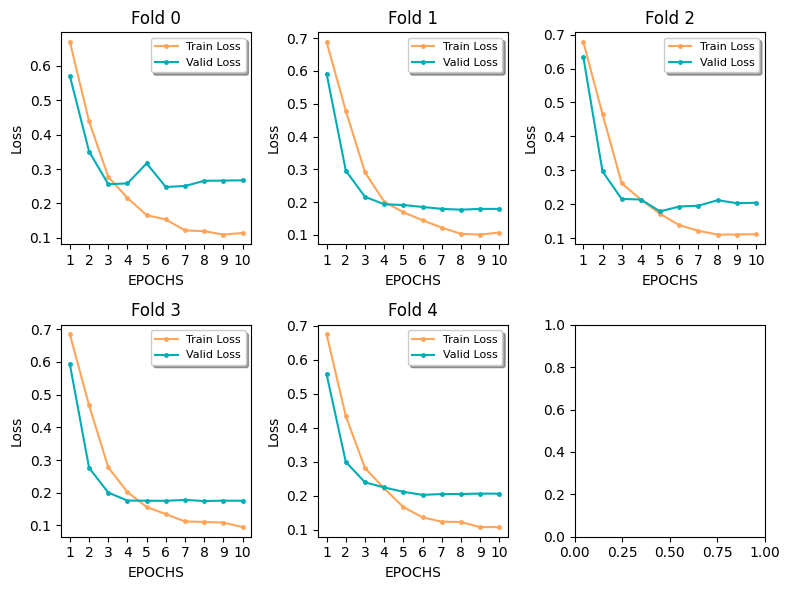

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(8,6))

# Fold 0
x = np.arange(1, 11)
y1, y2 = train_loss_each_fold_for_depict[0], valid_loss_each_fold_for_depict[0]

ax[0,0].plot(x, y1, color='#FFA559', linestyle="-", markersize="5", marker=".", label="Train Loss")
ax[0,0].plot(x, y2, color='#00ADB5', linestyle="-", markersize="5", marker=".", label="Valid Loss")
ax[0,0].set_title('Fold 0')
ax[0,0].legend(loc='upper right', shadow=True, fontsize=8)
ax[0,0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax[0,0].set_xlabel('EPOCHS')
ax[0,0].set_ylabel('Loss')

# Fold 1
y1, y2 = train_loss_each_fold_for_depict[1], valid_loss_each_fold_for_depict[1]

ax[0,1].plot(x, y1, color='#FFA559', linestyle="-", markersize="5", marker=".", label="Train Loss")
ax[0,1].plot(x, y2, color='#00ADB5', linestyle="-", markersize="5", marker=".", label="Valid Loss")
ax[0,1].set_title('Fold 1')
ax[0,1].legend(loc='upper right', shadow=True, fontsize=8)
ax[0,1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax[0,1].set_xlabel('EPOCHS')
ax[0,1].set_ylabel('Loss')

# Fold 2
y1, y2 = train_loss_each_fold_for_depict[2], valid_loss_each_fold_for_depict[2]

ax[0,2].plot(x, y1, color='#FFA559', linestyle="-", markersize="5", marker=".", label="Train Loss")
ax[0,2].plot(x, y2, color='#00ADB5', linestyle="-", markersize="5", marker=".", label="Valid Loss")
ax[0,2].set_title('Fold 2')
ax[0,2].legend(loc='upper right', shadow=True, fontsize=8)
ax[0,2].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax[0,2].set_xlabel('EPOCHS')
ax[0,2].set_ylabel('Loss')

# Fold 3
y1, y2 = train_loss_each_fold_for_depict[3], valid_loss_each_fold_for_depict[3]

ax[1,0].plot(x, y1, color='#FFA559', linestyle="-", markersize="5", marker=".", label="Train Loss")
ax[1,0].plot(x, y2, color='#00ADB5', linestyle="-", markersize="5", marker=".", label="Valid Loss")
ax[1,0].set_title('Fold 3')
ax[1,0].legend(loc='upper right', shadow=True, fontsize=8)
ax[1,0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax[1,0].set_xlabel('EPOCHS')
ax[1,0].set_ylabel('Loss')

# Fold 4
y1, y2 = train_loss_each_fold_for_depict[4], valid_loss_each_fold_for_depict[4]
ax[1,1].plot(x, y1, color='#FFA559', linestyle="-", markersize="5", marker=".", label="Train Loss")
ax[1,1].plot(x, y2, color='#00ADB5', linestyle="-", markersize="5", marker=".", label="Valid Loss")
ax[1,1].set_title('Fold 4')
ax[1,1].legend(loc='upper right', shadow=True, fontsize=8)
ax[1,1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax[1,1].set_xlabel('EPOCHS')
ax[1,1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Use fine tune model to predict

### Load models and import testing data

In [28]:
# Define tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [29]:
# Load fine tune model 
model = Roberta_Model()
model.to(device)
model.load_state_dict(torch.load('roberta_model.pth'))
model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Roberta_Model(
  (roberta_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [30]:
!gdown --id '1K9vaHi-FkL1sfVUIr53Q82dNXhKI8vDl' --output test_comments.csv  

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1K9vaHi-FkL1sfVUIr53Q82dNXhKI8vDl
To: /content/test_comments.csv
100% 1.97M/1.97M [00:00<00:00, 197MB/s]


In [31]:
test_comments = pd.read_csv('test_comments.csv')

In [32]:
test_comments = test_comments[7000:8000]
test_comments = test_comments[test_comments['grade'] != 1].reset_index(drop=True)
test_comments

comment  grade
0    Ugh going to town. I can never rest!  wants to...      0
1                           My twitter is on c r a c k      0
2    Okay so I`m trying to be happy and deal with m...      0
3                          _Dude Very nice. Good night      2
4                            that sounds foreboding...      0
..                                                 ...    ...
600                               Worried about friend      0
601   My Dad told me music that has the power to he...      2
602  Found out that a schoolmate died of an heart a...      0
603   I just added a butt to your name in my phone ...      2
604  So sorry if i`ve been typing wrongly. usually,...      0

[605 rows x 2 columns]

In [33]:
test_comments = test_comments.sample(frac=1).reset_index(drop=True)
test_comments['grade'] = test_comments['grade'].replace(2, 1)
test_comments # 1->positive, 0->negative

comment  grade
0    sorry dunners just saw your tweet! totally let...      0
1             Happy Mother`s Day to all the Mommiessss      1
2    About to be stick at work till freakin 2 am.  ...      0
3                                  I love you, though!      1
4    Doesnt feel good!  but I cant miss work tomorrow!      0
..                                                 ...    ...
600  i have the song here comes goodbye stuck in my...      0
601                                Yay for full-term!!      1
602  I wish I lived closer to the girls.  I`m tryna...      1
603                      i really am going to miss you      0
604   episode 17 season 1, i love chuck bass.  who`...      1

[605 rows x 2 columns]

In [34]:
all_dataset = Comment_Data(test_comments, tokenizer, 64)
all_dataloader = DataLoader(all_dataset, batch_size = 64, num_workers = 4)

all_predicts = []
all_targets = []

for batch in all_dataloader:
    ids = batch["ids"].to(device, dtype=torch.long)
    masks = batch["masks"].to(device, dtype=torch.long)
    token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
    targets = batch["targets"].to(device, dtype=torch.long)
    
    with torch.no_grad():
        outputs = model(ids, masks, token_type_ids)
        predicts = torch.argmax(outputs.data, dim=1)
    
    predicts = predicts.cpu().numpy()
    targets = targets.cpu().numpy()

    all_predicts.append(predicts)
    all_targets.append(targets)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
all_predict_array = np.array([])
all_target_array = np.array([])

for predict in all_predicts:
  all_predict_array = np.concatenate((predict, all_predict_array), axis=0)

for targets in all_targets:
  all_target_array = np.concatenate((targets, all_target_array), axis=0)

#### Confusion matrix

In [36]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

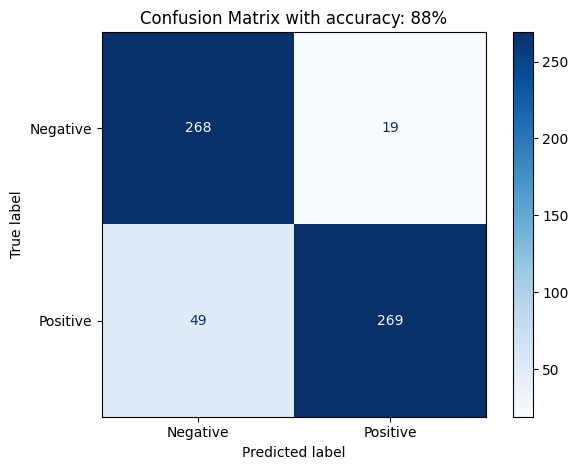

In [37]:
ex_classes = {'Classes': ['Negative', 'Positive']}

df_classes = pd.DataFrame(data=ex_classes)
label_enc = LabelEncoder()
label_enc.fit(df_classes['Classes'])

accuracy_nn = metrics.accuracy_score(all_target_array, all_predict_array)
confusion_matrix_nn = metrics.confusion_matrix(all_target_array, all_predict_array)

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_nn, display_labels=label_enc.classes_)
display = display.plot(cmap=plt.cm.Blues,values_format='g')

plt.title(f"Confusion Matrix with accuracy: {int(accuracy_nn*100)}%")
plt.tight_layout()
plt.show()

In [38]:
# Define the input text
input_text = "I really love the noodles"

In [39]:
# Tokenize the input text and convert to a PyTorch tensor

text = str(input_text)
text = " ".join(text.split())

inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens = True, 
            max_length = 64,
            padding = "max_length", 
            truncation = True,
            return_token_type_ids = True
        )

ids = inputs['input_ids'] 
masks = inputs['attention_mask'] 
token_type_ids = inputs["token_type_ids"]

ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
masks = torch.tensor(masks, dtype=torch.long).unsqueeze(0).to(device)
token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0).to(device)


# Perform sentiment analysis using the model
with torch.no_grad():
    outputs = model(ids, masks, token_type_ids)
    sentiment_class = torch.argmax(outputs.data, dim=1)

# Display the result
if sentiment_class == 1:
    print(f"The sentiment of the input text is positive.")
else:
    print(f"The sentiment of the input text is negative.")

The sentiment of the input text is positive.


### Scrape comments on google and predict

In [40]:
# Scrape a restaurant's comments on google map

import requests
import json
import pandas as pd

params = {
   'authuser': '0',
    'hl': 'en',
    'gl': 'tw',
    'pb': '!1m2!1y9263761784752308225!2y11583571783532055353!2m1!2i10!3e1!4m6!3b1!4b1!5b1!6b1!7b1!20b1!5m2!1sKbVnZKjSNozL-Qai-K9g!7e81'
}

cnt = 0
comments = []
error_cnt =0
flag = 0

while(1):
    params['pb'] = f'!1m2!1y9263761784752308225!2y11583571783532055353!2m1!2i{cnt*10}!3e1!4m6!3b1!4b1!5b1!6b1!7b1!20b1!5m2!1sKbVnZKjSNozL-Qai-K9g!7e81'
    r = requests.get('https://www.google.com/maps/preview/review/listentitiesreviews?' ,params=params)

    if r.status_code == 200:
        r_json = json.loads(r.text[4:])
        for i in r_json[2]:
            if i[3] == None:
                error_cnt+=1
            else:
                comments.append(i[3])
                error_cnt = 0
            if error_cnt ==10:
                flag = 1
        if flag:
            break
        cnt+=1
    else:
        error_cnt += 1
        if error_cnt == 10:
            break

google_comment_scrape = pd.DataFrame({"comment":comments})

In [41]:
google_comment_scrape

comment
0     I was looking for a late-night spot for tacos ...
1     The food here is terrible - don't believe the ...
2     I order a carne asada plate , but the carne as...
3     Great spot for tacos. The staff were very nice...
4     Ordered from Door Dash and it arrived quick an...
...                                                 ...
2115                                               Good
2116                        Insainly delicious tacos...
2117                                         Great food
2118                                       Food is good
2119                                       No complaint

[2120 rows x 1 columns]

In [42]:
# Remove duplicate reviews 
unique_comment_set = set(google_comment_scrape['comment'])
unique_comments = list(unique_comment_set)

google_comment_df = pd.DataFrame({"comment":unique_comments})
google_comment_df['grade'] = 0
google_comment_df

comment  grade
0                                                 Good      0
1    Good flavors, clean the only con is stale chip...      0
2    Love the food so tasty and employees are so fr...      0
3    Food was just ok. They visited our neighborhoo...      0
4                                       Carnitas. Bomb      0
..                                                 ...    ...
192  Their food has improved, but I was so disappoi...      0
193  Just very average and the cashier was very rud...      0
194  Twice now in a row I placed an order through 2...      0
195                                          Bomb #🔥🤘💯      0
196  I love this place . This is my new favorite ta...      0

[197 rows x 2 columns]

#### Data cleaning

In [43]:
# Remove Emojis
def remove_emojis(text):
    # Remove emojis using regular expressions
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002500-\U00002BEF"  # chinese char
                    u"\U00002702-\U000027B0"
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    u"\U0001f926-\U0001f937"
                    u"\U00010000-\U0010ffff"
                    u"\u2640-\u2642"
                    u"\u2600-\u2B55"
                    u"\u200d"
                    u"\u23cf"
                    u"\u23e9"
                    u"\u231a"
                    "\ufe0f"  # dingbats
                    "\u3030"
                    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Example usage
string = "Hello 😝 world! This is a 💯 test. 🌟🎉"

remove_emojis(string)

'Hello  world! This is a  test. '

In [44]:
# Remove URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
text = "Driverless AI NLP blog post on https://www.h2o.ai/blog/detecting-sarcasm-is-difficult-but-ai-may-have-an-answer/"

remove_urls(text)

'Driverless AI NLP blog post on '

In [45]:
clean_restaurant_comment = []
for comment in google_comment_df['comment']:
    comment = str(comment)
    remove_emojis(comment)
    remove_urls(comment)
    clean_restaurant_comment.append(comment)

google_comment_df.loc[:, 'comment'] = clean_restaurant_comment
google_comment_df 

comment  grade
0                                                 Good      0
1    Good flavors, clean the only con is stale chip...      0
2    Love the food so tasty and employees are so fr...      0
3    Food was just ok. They visited our neighborhoo...      0
4                                       Carnitas. Bomb      0
..                                                 ...    ...
192  Their food has improved, but I was so disappoi...      0
193  Just very average and the cashier was very rud...      0
194  Twice now in a row I placed an order through 2...      0
195                                          Bomb #🔥🤘💯      0
196  I love this place . This is my new favorite ta...      0

[197 rows x 2 columns]

#### Predict

In [46]:
# Load fine tune model on cpu 
model = Roberta_Model()
model.load_state_dict(torch.load('roberta_model.pth'))
model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Roberta_Model(
  (roberta_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [47]:
comments_grades = []

for text in google_comment_df['comment']:
    text = str(text)
    text = " ".join(text.split())

    inputs = tokenizer.encode_plus(
                text,
                None,
                add_special_tokens = True, 
                max_length = 64,
                padding = "max_length", 
                truncation = True,
                return_token_type_ids = True
            )

    ids = inputs['input_ids'] 
    masks = inputs['attention_mask'] 
    token_type_ids = inputs["token_type_ids"]

    ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    masks = torch.tensor(masks, dtype=torch.long).unsqueeze(0)
    token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)


    # Perform sentiment analysis using the model
    with torch.no_grad():
        outputs = model(ids, masks, token_type_ids)
        sentiment_class = torch.argmax(outputs.data, dim=1)
        comments_grades.append(sentiment_class.item())

google_comment_df['grade'] = comments_grades
google_comment_df

comment  grade
0                                                 Good      1
1    Good flavors, clean the only con is stale chip...      1
2    Love the food so tasty and employees are so fr...      1
3    Food was just ok. They visited our neighborhoo...      0
4                                       Carnitas. Bomb      0
..                                                 ...    ...
192  Their food has improved, but I was so disappoi...      0
193  Just very average and the cashier was very rud...      0
194  Twice now in a row I placed an order through 2...      0
195                                          Bomb #🔥🤘💯      0
196  I love this place . This is my new favorite ta...      1

[197 rows x 2 columns]

In [48]:
# model.to(device)
# model.eval()

In [49]:
# google_comment_dataset = Comment_Data(google_comment_df, tokenizer, 64)
# google_comment_dataloader = DataLoader(google_comment_dataset, batch_size = 64, num_workers = 4)

# all_predicts = []

# for batch in google_comment_dataloader:
#     ids = batch["ids"].to(device, dtype=torch.long)
#     masks = batch["masks"].to(device, dtype=torch.long)
#     token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
#     targets = batch["targets"].to(device, dtype=torch.long)
    
#     with torch.no_grad():
#         outputs = model(ids, masks, token_type_ids)
#         predicts = torch.argmax(outputs.data, dim=1)
    
#     predicts = predicts.cpu().numpy()
#     targets = targets.cpu().numpy()

#     all_predicts.append(predicts)

In [50]:
# all_predict_np = np.array([])

# for predict in all_predicts:
#   all_predict_np = np.concatenate((predict, all_predict_np), axis=0)
  
# google_comment_df['grade'] = all_predict_np.astype(int)
# google_comment_df

#### Remove stopwords and do pos select

In [51]:
!pip3 install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import spacy
import re

In [53]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [54]:
pos_select = ["VERB", "NOUN", "ADJ", "ADV", "PART"]

def remove_stopwords_and_pos_select(df):
    df_preprocess = []
    
    for comment in df['comment']:
      doc = nlp(comment)

      token_lemma = " ".join([token.lemma_.lower() for token in doc if (token.pos_ in pos_select and not token.is_stop)])
      df_preprocess.append(token_lemma)
      
    return df_preprocess

In [55]:
google_negative_comment = google_comment_df[google_comment_df['grade'] == 0]
google_positive_comment = google_comment_df[google_comment_df['grade'] == 1]

In [56]:
# Remove stopwords and do pos select
google_negative_comment['comment'] = remove_stopwords_and_pos_select(google_negative_comment)
google_positive_comment['comment'] = remove_stopwords_and_pos_select(google_positive_comment)

<ipython-input-56-c62df1cb4b6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_negative_comment['comment'] = remove_stopwords_and_pos_select(google_negative_comment)
<ipython-input-56-c62df1cb4b6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_positive_comment['comment'] = remove_stopwords_and_pos_select(google_positive_comment)


In [57]:
google_negative_comment = google_negative_comment.drop(google_negative_comment[google_negative_comment['comment'] == ''].index)
google_negative_comment.reset_index(drop=True)
google_negative_comment

comment  grade
3    food ok visit neighborhood great order miss it...      0
4                                                 bomb      0
5               vegetarian option rude little bit chip      0
6    rate get lucky star order mess get chip bag ri...      0
9                                            complaint      0
16   taquería usually open late weekend bit slow se...      0
17                                bad customer service      0
26   horrible customer service ask extra salsa lady...      0
27   bad place bother waste ypure money teach peopl...      0
28   let start say compare taqueria walk distance a...      0
30   come order food post maid driver think cut wai...      0
37    bad mexican food try expensive waste money place      0
40   live block away tome get home husband burrito ...      0
41   horrible experience order super burrito absolu...      0
43              old egtl know year chip suck salsa meh      0
47               steak quesadilla cold expensive price      0
48               love spot miss 30th mission form fire      0
50   alright friendly staff sense urgency patronize...      0
51   nachos good store buy carne cook dish flavor g...      0
52   kind disappointed know order postmate food qua...      0
56                       buy nachos hair nasty af away      0
58   meet owner build relationship give job ask stu...      0
60                                                gran      0
62   * eat past year happen phone takeaway order wa...      0
68   price comparison quality food costumer service...      0
73                                                good      0
81   disappoint today order shrimp burrito arrive b...      0
104                                       fast service      0
107  get order prepare ultimate laziness example ch...      0
112  food absolutely disgusting finish waste money eat      0
113  ask steak fry cashier bad attitude instead wor...      0
116  miss burn 29th mission second time evening mor...      0
118      order burrito say bean home burrito bean like      0
121  buy food food truck park lady cashier food tru...      0
122  food guess bit slow staff friendly crack smile...      0
126           service terrible favor try taqueria door      0
129  burritos order mediocre taqueria come burrito ...      0
130            take minute burrito communication order      0
132  not taco special taste okay carne small taco o...      0
133                       pastor cook salty clam gross      0
135  flavor meat charge extra carne charge extra fe...      0
138  not like food expect woul hit favorite spot as...      0
149  order right order pick order order right quali...      0
152         friendly people price high recommend place      0
159                                         roach wall      0
161  horrible place pay card hurry turn screen tip ...      0
162  place respect customer time order wait hrs act...      0
163  place control charge food add percent menus it...      0
169                eat food bit bit cold good erving e      0
170  unfortunately disappointment price go signific...      0
171  food terrible believe fake star review honestl...      0
175                           food salty watery flavor      0
179  guy prepare food take mask atarted talk food g...      0
181  good food order item get home sure uou check o...      0
187  3rd time order ask onion food allergic time re...      0
189  order carne asada plate carne carne cheap stea...      0
192  food improve disappointed menudo soup meat lit...      0
193                    average cashier rude condescend      0
194  twice row place order good charge arrive recei...      0
195                                           bomb 🔥 💯      0

In [58]:
google_positive_comment = google_positive_comment.drop(google_positive_comment[google_positive_comment['comment'] == ''].index)
google_positive_comment.reset_index(drop=True)
google_positive_comment

comment  grade
0                                                 good      1
1                good flavor clean con stale chip spot      1
2    love food tasty employee friendly cashier frie...      1
7          love place order week shrimp burritos thank      1
8                                       food delicious      1
..                                                 ...    ...
186                    fix heater cold food good yummm      1
188                                           good gut      1
190                           open late plenty seating      1
191              good town fresh food time free refill      1
196  love place new favorite taqueria food good sel...      1

[132 rows x 2 columns]

#### Remove neutral comments using VADER

In [59]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [60]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [61]:
sia = SentimentIntensityAnalyzer()

sia.polarity_scores("Burger is good")

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}

In [62]:
score_dic = {}
neg_score_list = []
neu_score_list = []
pos_score_list = []

for comment in google_negative_comment['comment']:
    score_dic = sia.polarity_scores(comment)
    neg_score_list.append(score_dic['compound'])

for comment in google_positive_comment['comment']:
    score_dic = sia.polarity_scores(comment)
    pos_score_list.append(score_dic['compound'])

In [63]:
google_negative_comment['compound'] = neg_score_list
google_positive_comment['compound'] = pos_score_list

In [64]:
google_negative_comment

comment  grade  compound
3    food ok visit neighborhood great order miss it...      0    0.8235
4                                                 bomb      0   -0.4939
5               vegetarian option rude little bit chip      0   -0.4588
6    rate get lucky star order mess get chip bag ri...      0    0.8020
9                                            complaint      0   -0.2960
16   taquería usually open late weekend bit slow se...      0    0.6597
17                                bad customer service      0   -0.5423
26   horrible customer service ask extra salsa lady...      0   -0.5423
27   bad place bother waste ypure money teach peopl...      0   -0.8271
28   let start say compare taqueria walk distance a...      0    0.7579
30   come order food post maid driver think cut wai...      0    0.4404
37    bad mexican food try expensive waste money place      0   -0.7430
40   live block away tome get home husband burrito ...      0   -0.4404
41   horrible experience order super burrito absolu...      0    0.8591
43              old egtl know year chip suck salsa meh      0   -0.4939
47               steak quesadilla cold expensive price      0    0.0000
48               love spot miss 30th mission form fire      0    0.2960
50   alright friendly staff sense urgency patronize...      0    0.5574
51   nachos good store buy carne cook dish flavor g...      0    0.7964
52   kind disappointed know order postmate food qua...      0    0.6249
56                       buy nachos hair nasty af away      0   -0.5574
58   meet owner build relationship give job ask stu...      0   -0.6124
60                                                gran      0    0.0000
62   * eat past year happen phone takeaway order wa...      0    0.8720
68   price comparison quality food costumer service...      0    0.0000
73                                                good      0    0.4404
81   disappoint today order shrimp burrito arrive b...      0   -0.6705
104                                       fast service      0    0.0000
107  get order prepare ultimate laziness example ch...      0   -0.2732
112  food absolutely disgusting finish waste money eat      0   -0.7755
113  ask steak fry cashier bad attitude instead wor...      0   -0.7650
116  miss burn 29th mission second time evening mor...      0    0.3182
118      order burrito say bean home burrito bean like      0    0.3612
121  buy food food truck park lady cashier food tru...      0   -0.9565
122  food guess bit slow staff friendly crack smile...      0    0.5256
126           service terrible favor try taqueria door      0   -0.1027
129  burritos order mediocre taqueria come burrito ...      0    0.9545
130            take minute burrito communication order      0    0.0000
132  not taco special taste okay carne small taco o...      0    0.4295
133                       pastor cook salty clam gross      0   -0.4767
135  flavor meat charge extra carne charge extra fe...      0   -0.2415
138  not like food expect woul hit favorite spot as...      0    0.6694
149  order right order pick order order right quali...      0   -0.0516
152         friendly people price high recommend place      0    0.6908
159                                         roach wall      0    0.0000
161  horrible place pay card hurry turn screen tip ...      0   -0.9169
162  place respect customer time order wait hrs act...      0    0.4588
163  place control charge food add percent menus it...      0   -0.4767
169                eat food bit bit cold good erving e      0    0.4404
170  unfortunately disappointment price go signific...      0   -0.1027
171  food terrible believe fake star review honestl...      0   -0.3182
175                           food salty watery flavor      0    0.0000
179  guy prepare food take mask atarted talk food g...      0   -0.3818
181  good food order item get home sure uou check o...      0    0.6597
187  3rd time order ask onion food allergic time re...      0   -0.2263
189  order carn

In [65]:
sorted_negative_dataframe = google_negative_comment.sort_values('compound', ascending=True)
sorted_negative_dataframe = sorted_negative_dataframe.reset_index(drop=True)
sorted_negative_dataframe

comment  grade  compound
0   buy food food truck park lady cashier food tru...      0   -0.9565
1   horrible place pay card hurry turn screen tip ...      0   -0.9169
2   bad place bother waste ypure money teach peopl...      0   -0.8271
3   food absolutely disgusting finish waste money eat      0   -0.7755
4   ask steak fry cashier bad attitude instead wor...      0   -0.7650
5    bad mexican food try expensive waste money place      0   -0.7430
6   twice row place order good charge arrive recei...      0   -0.7096
7   disappoint today order shrimp burrito arrive b...      0   -0.6705
8   meet owner build relationship give job ask stu...      0   -0.6124
9                       buy nachos hair nasty af away      0   -0.5574
10                               bad customer service      0   -0.5423
11  horrible customer service ask extra salsa lady...      0   -0.5423
12             old egtl know year chip suck salsa meh      0   -0.4939
13                                           bomb 🔥 💯      0   -0.4939
14                                               bomb      0   -0.4939
15                       pastor cook salty clam gross      0   -0.4767
16  place control charge food add percent menus it...      0   -0.4767
17                    average cashier rude condescend      0   -0.4588
18             vegetarian option rude little bit chip      0   -0.4588
19  live block away tome get home husband burrito ...      0   -0.4404
20  guy prepare food take mask atarted talk food g...      0   -0.3818
21  food terrible believe fake star review honestl...      0   -0.3182
22                                          complaint      0   -0.2960
23  get order prepare ultimate laziness example ch...      0   -0.2732
24  flavor meat charge extra carne charge extra fe...      0   -0.2415
25  3rd time order ask onion food allergic time re...      0   -0.2263
26           service terrible favor try taqueria door      0   -0.1027
27  unfortunately disappointment price go signific...      0   -0.1027
28  food improve disappointed menudo soup meat lit...      0   -0.0790
29  order right order pick order order right quali...      0   -0.0516
30                           food salty watery flavor      0    0.0000
31                                         roach wall      0    0.0000
32            take minute burrito communication order      0    0.0000
33  order carne asada plate carne carne cheap stea...      0    0.0000
34              steak quesadilla cold expensive price      0    0.0000
35                                       fast service      0    0.0000
36  price comparison quality food costumer service...      0    0.0000
37                                               gran      0    0.0000
38              love spot miss 30th mission form fire      0    0.2960
39  miss burn 29th mission second time evening mor...      0    0.3182
40      order burrito say bean home burrito bean like      0    0.3612
41  not taco special taste okay carne small taco o...      0    0.4295
42                                               good      0    0.4404
43                eat food bit bit cold good erving e      0    0.4404
44  come order food post maid driver think cut wai...      0    0.4404
45  place respect customer time order wait hrs act...      0    0.4588
46  food guess bit slow staff friendly crack smile...      0    0.5256
47  alright friendly staff sense urgency patronize...      0    0.5574
48  kind disappointed know order postmate food qua...      0    0.6249
49  taquería usually open late weekend bit slow se...      0    0.6597
50  good food order item get home sure uou check o...      0    0.6597
51  not like food expect woul hit favorite spot as...      0    0.6694
52         friendly people price high recommend place      0    0.6908
53  let start say compare taqueria walk distance a...      0    0.7579
54  nachos good store buy carne cook dish flavor g...      0    0.7964
55  rate get lucky star order mess get chip bag ri...      0    0.8020

In [66]:
sorted_positive_dataframe = google_positive_comment.sort_values('compound', ascending=False)
sorted_positive_dataframe = sorted_positive_dataframe.reset_index(drop=True)
sorted_positive_dataframe

comment  grade  compound
0    love place food amazing flavorful delicious co...      1    0.9601
1    good food border excellent pastor delicious ca...      1    0.9451
2    good taco place clean people nice highly recom...      1    0.9432
3    great food friendly staff great catering glad ...      1    0.9371
4    great freshness food home feeling great servic...      1    0.9349
..                                                 ...    ...       ...
127                                          promotion      1    0.0000
128                                          food hook      1    0.0000
129                                           informed      1    0.0000
130  big plate fry smother nacho cheese top sour cr...      1   -0.2500
131  nice salsa bar great taco miss bernal height l...      1   -0.3400

[132 rows x 3 columns]

In [67]:
# Choose only top 30% of comments and turn it into list

total_neg_rows = len(sorted_negative_dataframe)
total_pos_rows = len(sorted_positive_dataframe)

top_30_neg_rows = int(total_neg_rows * 0.3)
top_30_pos_rows = int(total_pos_rows * 0.3)

google_negative_comment_df = sorted_negative_dataframe.head(top_30_neg_rows)
google_positive_comment_df = sorted_positive_dataframe.head(top_30_pos_rows)

google_negative_comment_list = google_negative_comment_df['comment'].tolist()
google_positive_comment_list = google_positive_comment_df['comment'].tolist()

In [68]:
# Turn all comments into a string
google_negative_mix = " ".join(google_negative_comment_list) 
google_positive_mix = " ".join(google_positive_comment_list) 

In [69]:
# Build fre list
Negative_fre_list =  google_negative_mix.split(" ")
Positive_fre_list =  google_positive_mix.split(" ")

In [70]:
print(Negative_fre_list)

['buy', 'food', 'food', 'truck', 'park', 'lady', 'cashier', 'food', 'truck', 'look', 'sick', 'coughing', 'sneeze', 'guy', 'prepare', 'burritos', 'bare', 'naked', 'hand', 'scoop', 'rice', 'ingredient', 'burritos', 'shocked', 'cashier', 'sneeze', 'clean', 'hand', 'hand', 'coke', 'call', 'manager', 'complain', 'unapologetic', 'recommend', 'employee', 'sick', 'sick', 'talk', 'cook', 'use', 'glove', 'spoon', 'prepare', 'food', 'food', 'truck', 'ask', 'complain', 'moment', 'tell', 'manager', 'unprofessional', 'naive', 'expect', 'apologize', 'experience', 'expect', 'tell', 'talk', 'employee', 'proper', 'way', 'operate', 'handle', 'food', 'disappointed', 'day', 'later', 'wake', 'fever', 'scratchy', 'throat', 'sneeze', 'force', 'sick', 'work', 'people', 'sick', 'mad', 'truck', 'health', 'service', 'paper', 'pass', 'operate', 'start', 'horrible', 'place', 'pay', 'card', 'hurry', 'turn', 'screen', 'tip', 'self', '%', 'bother', 'come', 'rude', 'nasty', 'food', 'bad', 'place', 'bother', 'waste', 'y

In [71]:
print(Positive_fre_list)

['love', 'place', 'food', 'amazing', 'flavorful', 'delicious', 'cook', 'properly', 'staff', 'amazing', 'nice', 'people', 'good', 'food', 'border', 'excellent', 'pastor', 'delicious', 'carnita', 'close', 'second', 'friendly', 'staff', 'clean', 'dinning', 'room', 'good', 'taco', 'place', 'clean', 'people', 'nice', 'highly', 'recommend', 'place', 'good', 'good', 'tasty', 'great', 'food', 'friendly', 'staff', 'great', 'catering', 'glad', 'able', 'open', 'store', 'burn', 'great', 'freshness', 'food', 'home', 'feeling', 'great', 'service', 'cleaniness', 'sure', 'friend', 'family', 'good', 'taco', 'hand', 'great', 'customer', 'service', 'super', 'quick', 'delicious', 'food', 'especially', 'worth', 'price', 'taco', 'employee', 'nice', 'give', 'instead', 'take', 'long', 'time', 'taco', 'worth', 'end', 'great', 'salsa', 'topping', 'selection', 'love', 'food', 'tasty', 'employee', 'friendly', 'cashier', 'friendly', 'welcoming', 'vegetarian', 'burritos', 'place', 'staple', 'food', 'month', 'pandem

### Depict word fre chart

In [72]:
from nltk import FreqDist

In [73]:
Neg_fdist = FreqDist(Negative_fre_list)
Pos_fdist = FreqDist(Positive_fre_list)

In [74]:
Neg_fdist

FreqDist({'food': 13, 'place': 6, 'sick': 5, 'bad': 5, 'truck': 4, 'cashier': 4, 'ask': 4, 'order': 4, 'charge': 4, 'sneeze': 3, ...})

In [75]:
Pos_fdist 

FreqDist({'food': 23, 'taco': 19, 'good': 18, 'great': 18, 'place': 17, 'love': 9, 'service': 9, 'delicious': 8, 'clean': 8, 'amazing': 6, ...})

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4)) 
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)
plt.rcParams["figure.figsize"] = (16, 12)

<Figure size 400x400 with 0 Axes>

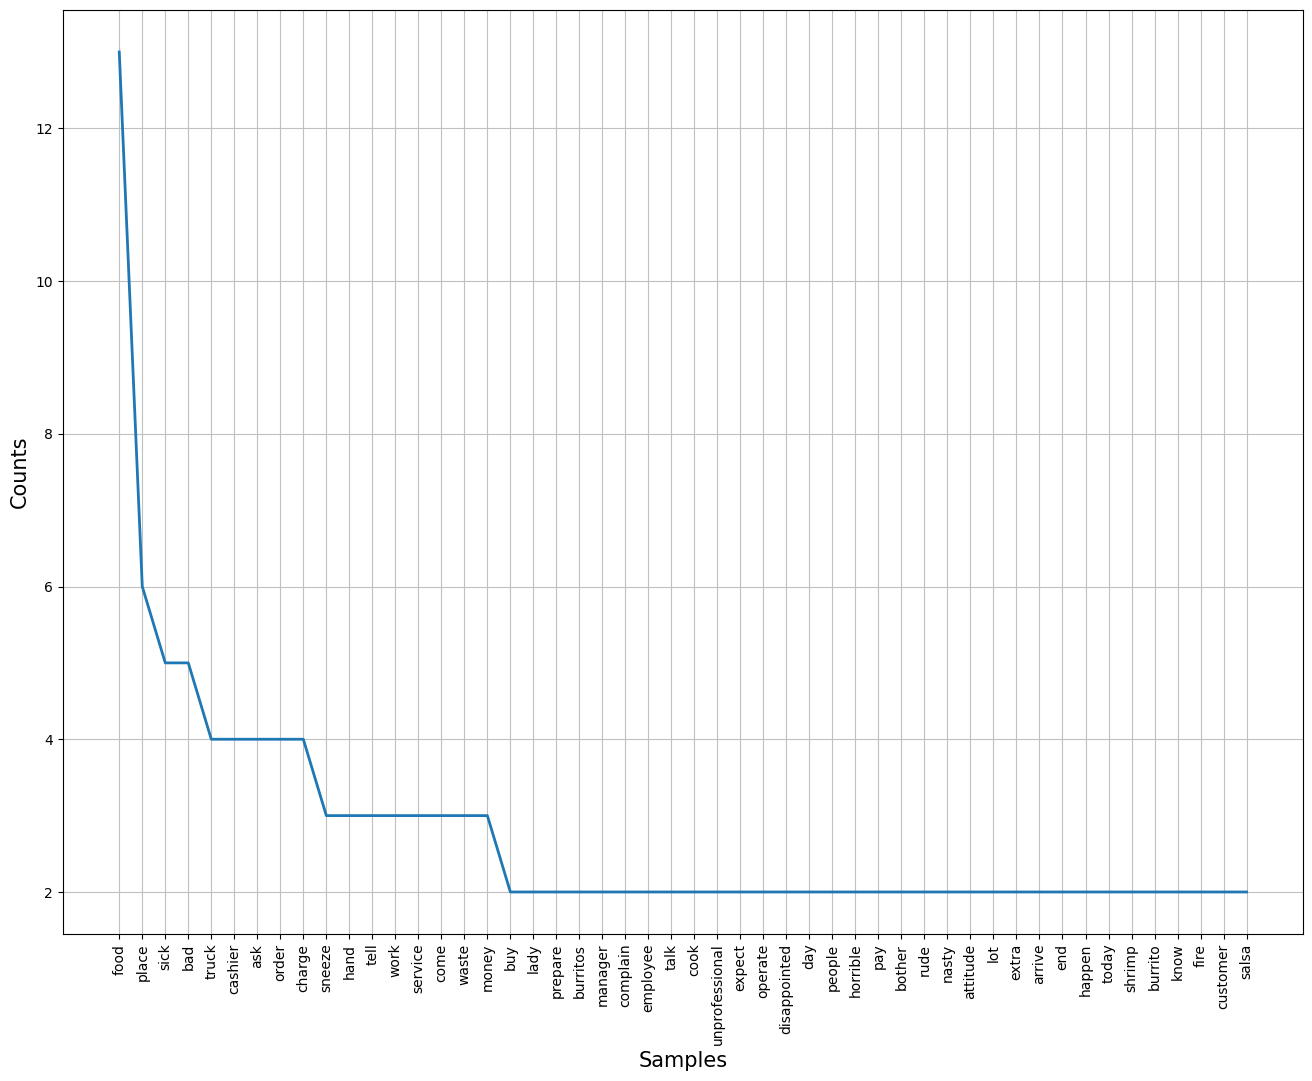

<Axes: xlabel='Samples', ylabel='Counts'>

In [77]:
Neg_fdist.plot(50, cumulative=False)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127790 (\N{TACO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


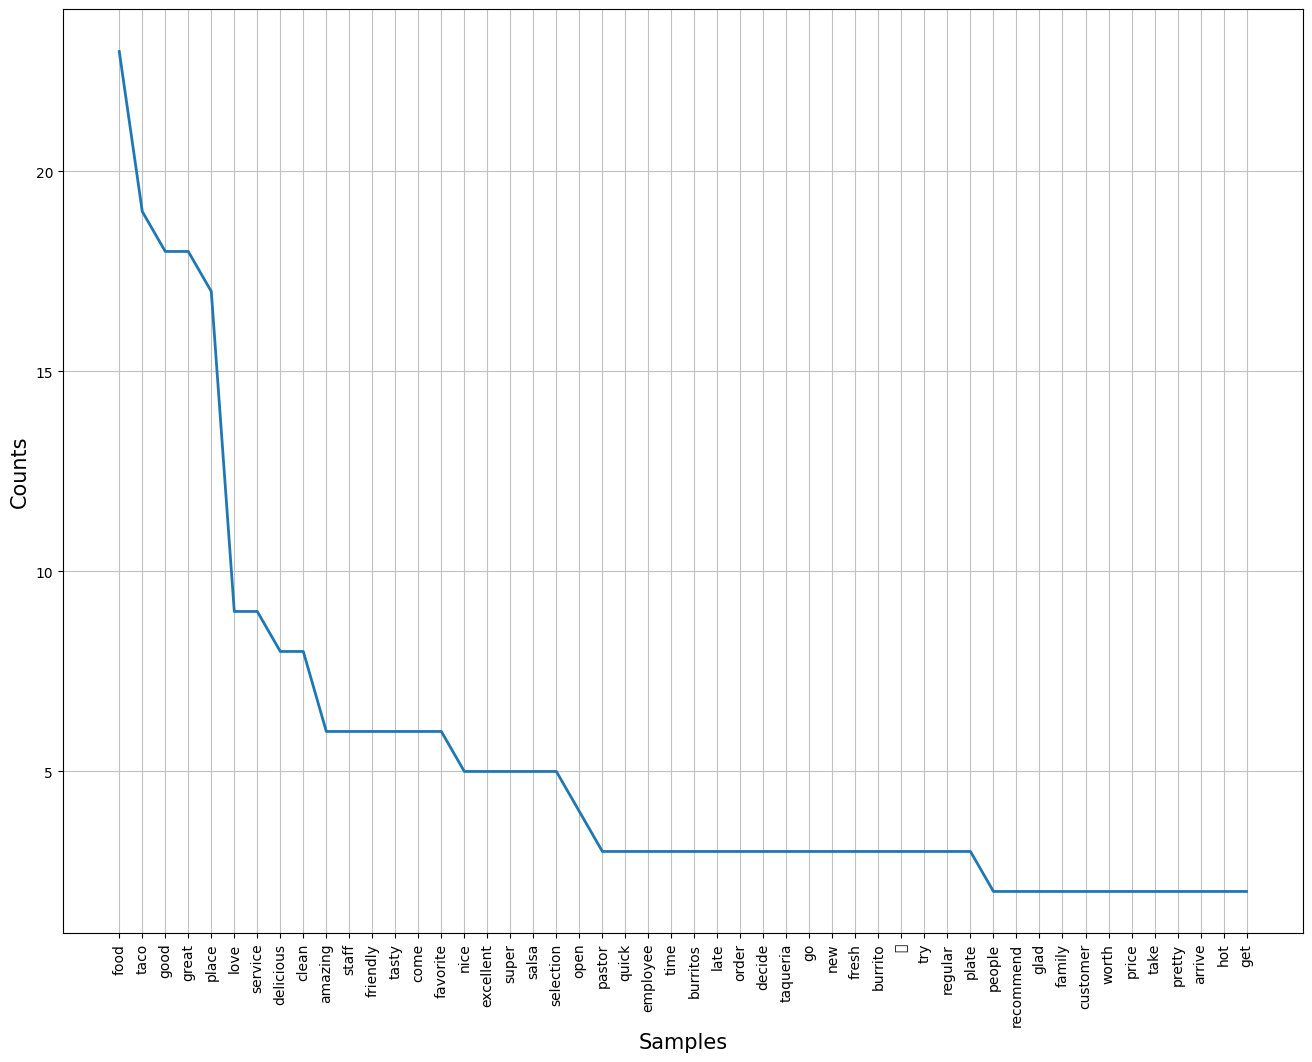

<Axes: xlabel='Samples', ylabel='Counts'>

In [78]:
Pos_fdist.plot(50, cumulative=False)

### Use k-medoids to do clustering and show results by t-SNE

First turn sentences into vector by doing tfidf

In [79]:
# If too many points on TSNE will decrease visibility, so we set max len(list) to 20
if len(google_negative_comment_list) > 20:
    google_negative_comment_TSNE = google_negative_comment_list[0:21]
    google_negative_comment_df = google_negative_comment_df[0:21]

else:
    google_negative_comment_TSNE = google_negative_comment_list


if len(google_positive_comment_list) > 20:
    google_positive_comment_TSNE = google_positive_comment_list[0:21]
    google_positive_comment_df = google_positive_comment_df[0:21]
else:
    google_positive_comment_TSNE = google_positive_comment_list

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features= None)

neg_feature_matrix = vectorizer.fit_transform(google_negative_comment_TSNE).astype(float)

neg_feature_names = vectorizer.get_feature_names_out() 
print("number of feature:", len(neg_feature_names))

number of feature: 172


In [81]:
feature_df = pd.DataFrame(neg_feature_matrix.toarray(),columns=[neg_feature_names])
feature_df

absolutely       add        af apologize    arrive       ask  attitude  \
0    0.000000  0.000000  0.000000  0.081908  0.000000  0.058825  0.000000   
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.425362  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.178651  0.217734   
5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6    0.000000  0.000000  0.000000  0.000000  0.188121  0.000000  0.000000   
7    0.000000  0.000000  0.000000  0.000000  0.182834  0.000000  0.000000   
8    0.000000  0.000000  0.000000  0.000000  0.000000  0.181988  0.000000   
9    0.000000  0.000000  0.425156  0.000000  0.000000  0.000000  0.000000   
10   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11   0.000000  0.000000  0.000000  0.000000  0.000000  0.196118  0.239023   
12   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16   0.000000  0.217616  0.000000  0.000000  0.000000  0.000000  0.000000   
17   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

    average      away       bad  ...       use      wake     waste     watch  \
0   0.00000  0.000000  0.000000  ...  0.081908  0.081908  0.000000  0.000000   
1   0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2   0.00000  0.000000  0.257984  ...  0.000000  0.000000  0.306576  0.000000   
3   0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.334678  0.000000   
4   0.00000  0.000000  0.164701  ...  0.000000  0.000000  0.000000  0.248756   
5   0.00000  0.000000  0.286434  ...  0.000000  0.000000  0.340385  0.000000   
6   0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
7   0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
8   0.00000  0.000000  0.167778  ...  0.000000  0.000000  0.000000  0.000000   
9   0.00000  0.425156  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
10  0.00000  0.000000  0.490299  ...  0.000000  0.000000  0.000000  0.000000   
11  0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
12  0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
13  0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
14  0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
15  0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
16  0.00000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
17  0.54351  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

         way      work   working     world      year     ypure  
0   0.081908  0.064446  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.389645  
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.248756  0.000000  0.000000  0.000000  
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6   0.000000  0.000000  0.000000  0.214924  0.000000  0.000000  
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
8   0.000000  0.199379  0.000000  0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
11  0.000000  0.214860  0.000000  0.000000  0.000000  0.000000  
12  0.000000  0.000000  0.000000  0.000000  0.364365  0.000000  
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
14  0.000000  0.000000  0.000000  0.000000 

In [82]:
from sklearn_extra.cluster import KMedoids

In [83]:
def k_medoids(feature_matrix, num_clusters=5):
    kmedoids = KMedoids(n_clusters=num_clusters, init='k-medoids++', random_state=1, max_iter=10000)
    kmedoids.fit(feature_matrix)
    clusters = kmedoids.labels_

    return kmedoids, clusters

In [84]:
num_clusters = 4

km_obj, km_clusters = k_medoids(feature_matrix=neg_feature_matrix, num_clusters=num_clusters)

google_negative_comment_df['Cluster'] = km_clusters

<ipython-input-84-6259ab756925>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_negative_comment_df['Cluster'] = km_clusters


In [85]:
from sklearn.manifold import TSNE

In [86]:
colors = ['#48D1CC', '#9ACD32', '#CD5C5C','#CD853F','#FFC0CB','#BC8F8F','#DDA0DD','#E5CF9C']

color_name_to_rgb = {
    'Medium Turquoise': '#48D1CC',
    'Yellow Green': '#9ACD32',
    'Indian Red': '#CD5C5C',
    'Peru': '#CD853F',
    'pink': '#FFC0CB',
    'Rosy Brown': '#BC8F8F',
    'Plum': '#DDA0DD',
    'Mimosa': '#E5CF9C'
}

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128175 (\N{HUNDRED POINTS SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


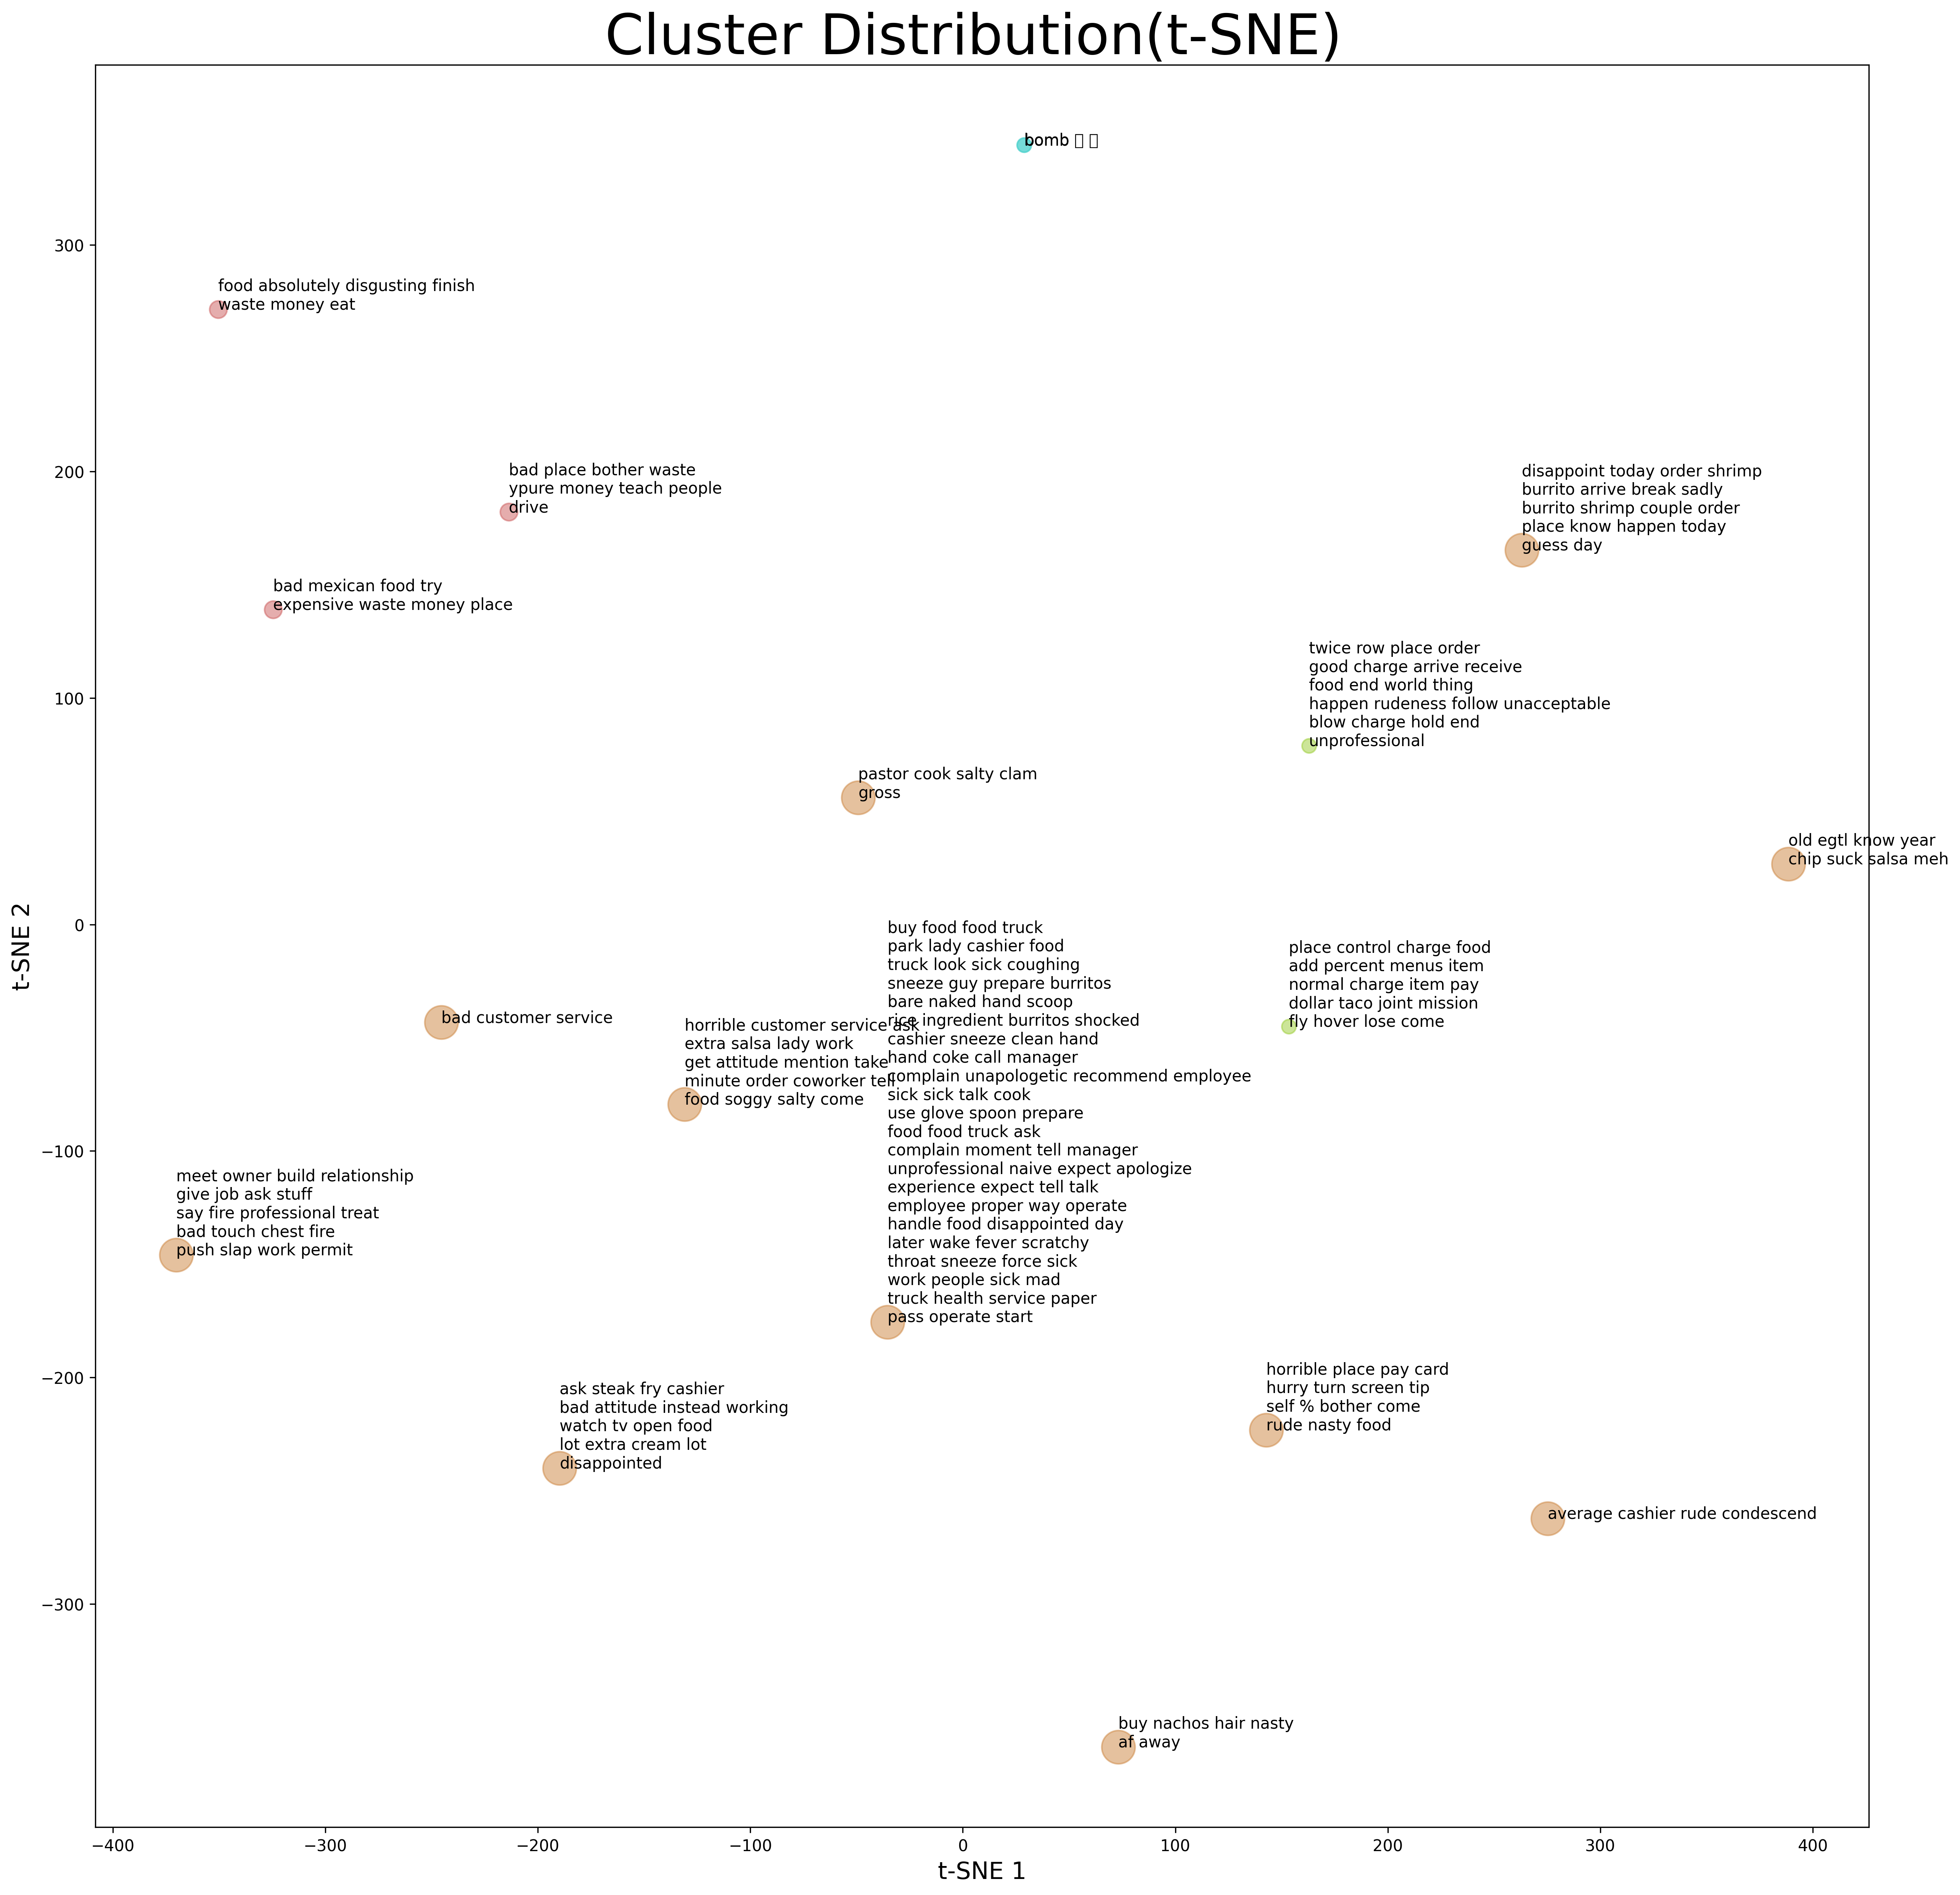

In [87]:
tsne = TSNE(n_components=2, perplexity=10, random_state=0)
tsne_matrix = tsne.fit_transform(neg_feature_matrix.toarray())

# create scatterplot of the data
plt.figure(figsize=(20,20), dpi=300)

for i in range(num_clusters):
    cluster_data = google_negative_comment_df[google_negative_comment_df['Cluster'] == i]
    plt.scatter(tsne_matrix[km_clusters==i, 0], tsne_matrix[km_clusters==i, 1], c=colors[i], alpha=0.5, label=f'Cluster {i}', s=cluster_data.shape[0]*40)
    for j, txt in enumerate(google_negative_comment_df[google_negative_comment_df['Cluster'] == i]['comment']):
        words = txt.split()
        txt_lines = [words[k:k+4] for k in range(0, len(words), 4)]  
        txt = '\n'.join([' '.join(line) for line in txt_lines]) 
        plt.annotate(txt, (tsne_matrix[km_clusters==i, 0][j], tsne_matrix[km_clusters==i, 1][j]), fontsize=10)

plt.title('Cluster Distribution(t-SNE) ')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


In [88]:
pos_feature_matrix = vectorizer.fit_transform(google_positive_comment_TSNE).astype(float)

pos_feature_names = vectorizer.get_feature_names_out() 
print("number of feature:", len(pos_feature_names))

number of feature: 142


In [89]:
feature_df = pd.DataFrame(pos_feature_matrix.toarray(),columns=[pos_feature_names])
feature_df

able   amazing   amplify   anymore    arrive atmosphere   awesome  \
0   0.000000  0.580366  0.000000  0.000000  0.000000   0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
3   0.366519  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.208086   0.000000  0.000000   
10  0.000000  0.000000  0.250774  0.000000  0.000000   0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.308617  0.000000   0.000000  0.000000   
12  0.000000  0.000000  0.000000  0.000000  0.000000   0.336421  0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.719397   
14  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
17  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
18  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
19  0.000000  0.363473  0.000000  0.000000  0.000000   0.000000  0.000000   
20  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   

         bar    border breakfast  ...   topping       try   usually  \
0   0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
1   0.000000  0.318578   0.00000  ...  0.000000  0.000000  0.000000   
2   0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
3   0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
4   0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
5   0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
6   0.000000  0.000000   0.00000  ...  0.251028  0.000000  0.000000   
7   0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
8   0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
9   0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
10  0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
11  0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
12  0.336421  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
13  0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
14  0.000000  0.000000   0.44752  ...  0.000000  0.000000  0.000000   
15  0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
16  0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
17  0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
18  0.000000  0.000000   0.00000  ...  0.000000  0.251007  0.251007   
19  0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   
20  0.000000  0.000000   0.00000  ...  0.000000  0.000000  0.000000   

   vegetarian      wall      want welcoming      wife     worth    yummy  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
6    0.000000  0.000000  0.000000  0.000000  0.000000  0.502056  0.00000  
7    0.000000  0.000000  0.000000  0.403199  0.000000  0.000000  0.00000  
8    0.322536  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  


In [90]:
num_clusters = 4

km_obj, km_clusters = k_medoids(feature_matrix=pos_feature_matrix, num_clusters=num_clusters)

google_positive_comment_df['Cluster'] = km_clusters

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127790 (\N{TACO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127791 (\N{BURRITO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129303 (\N{HUGGING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


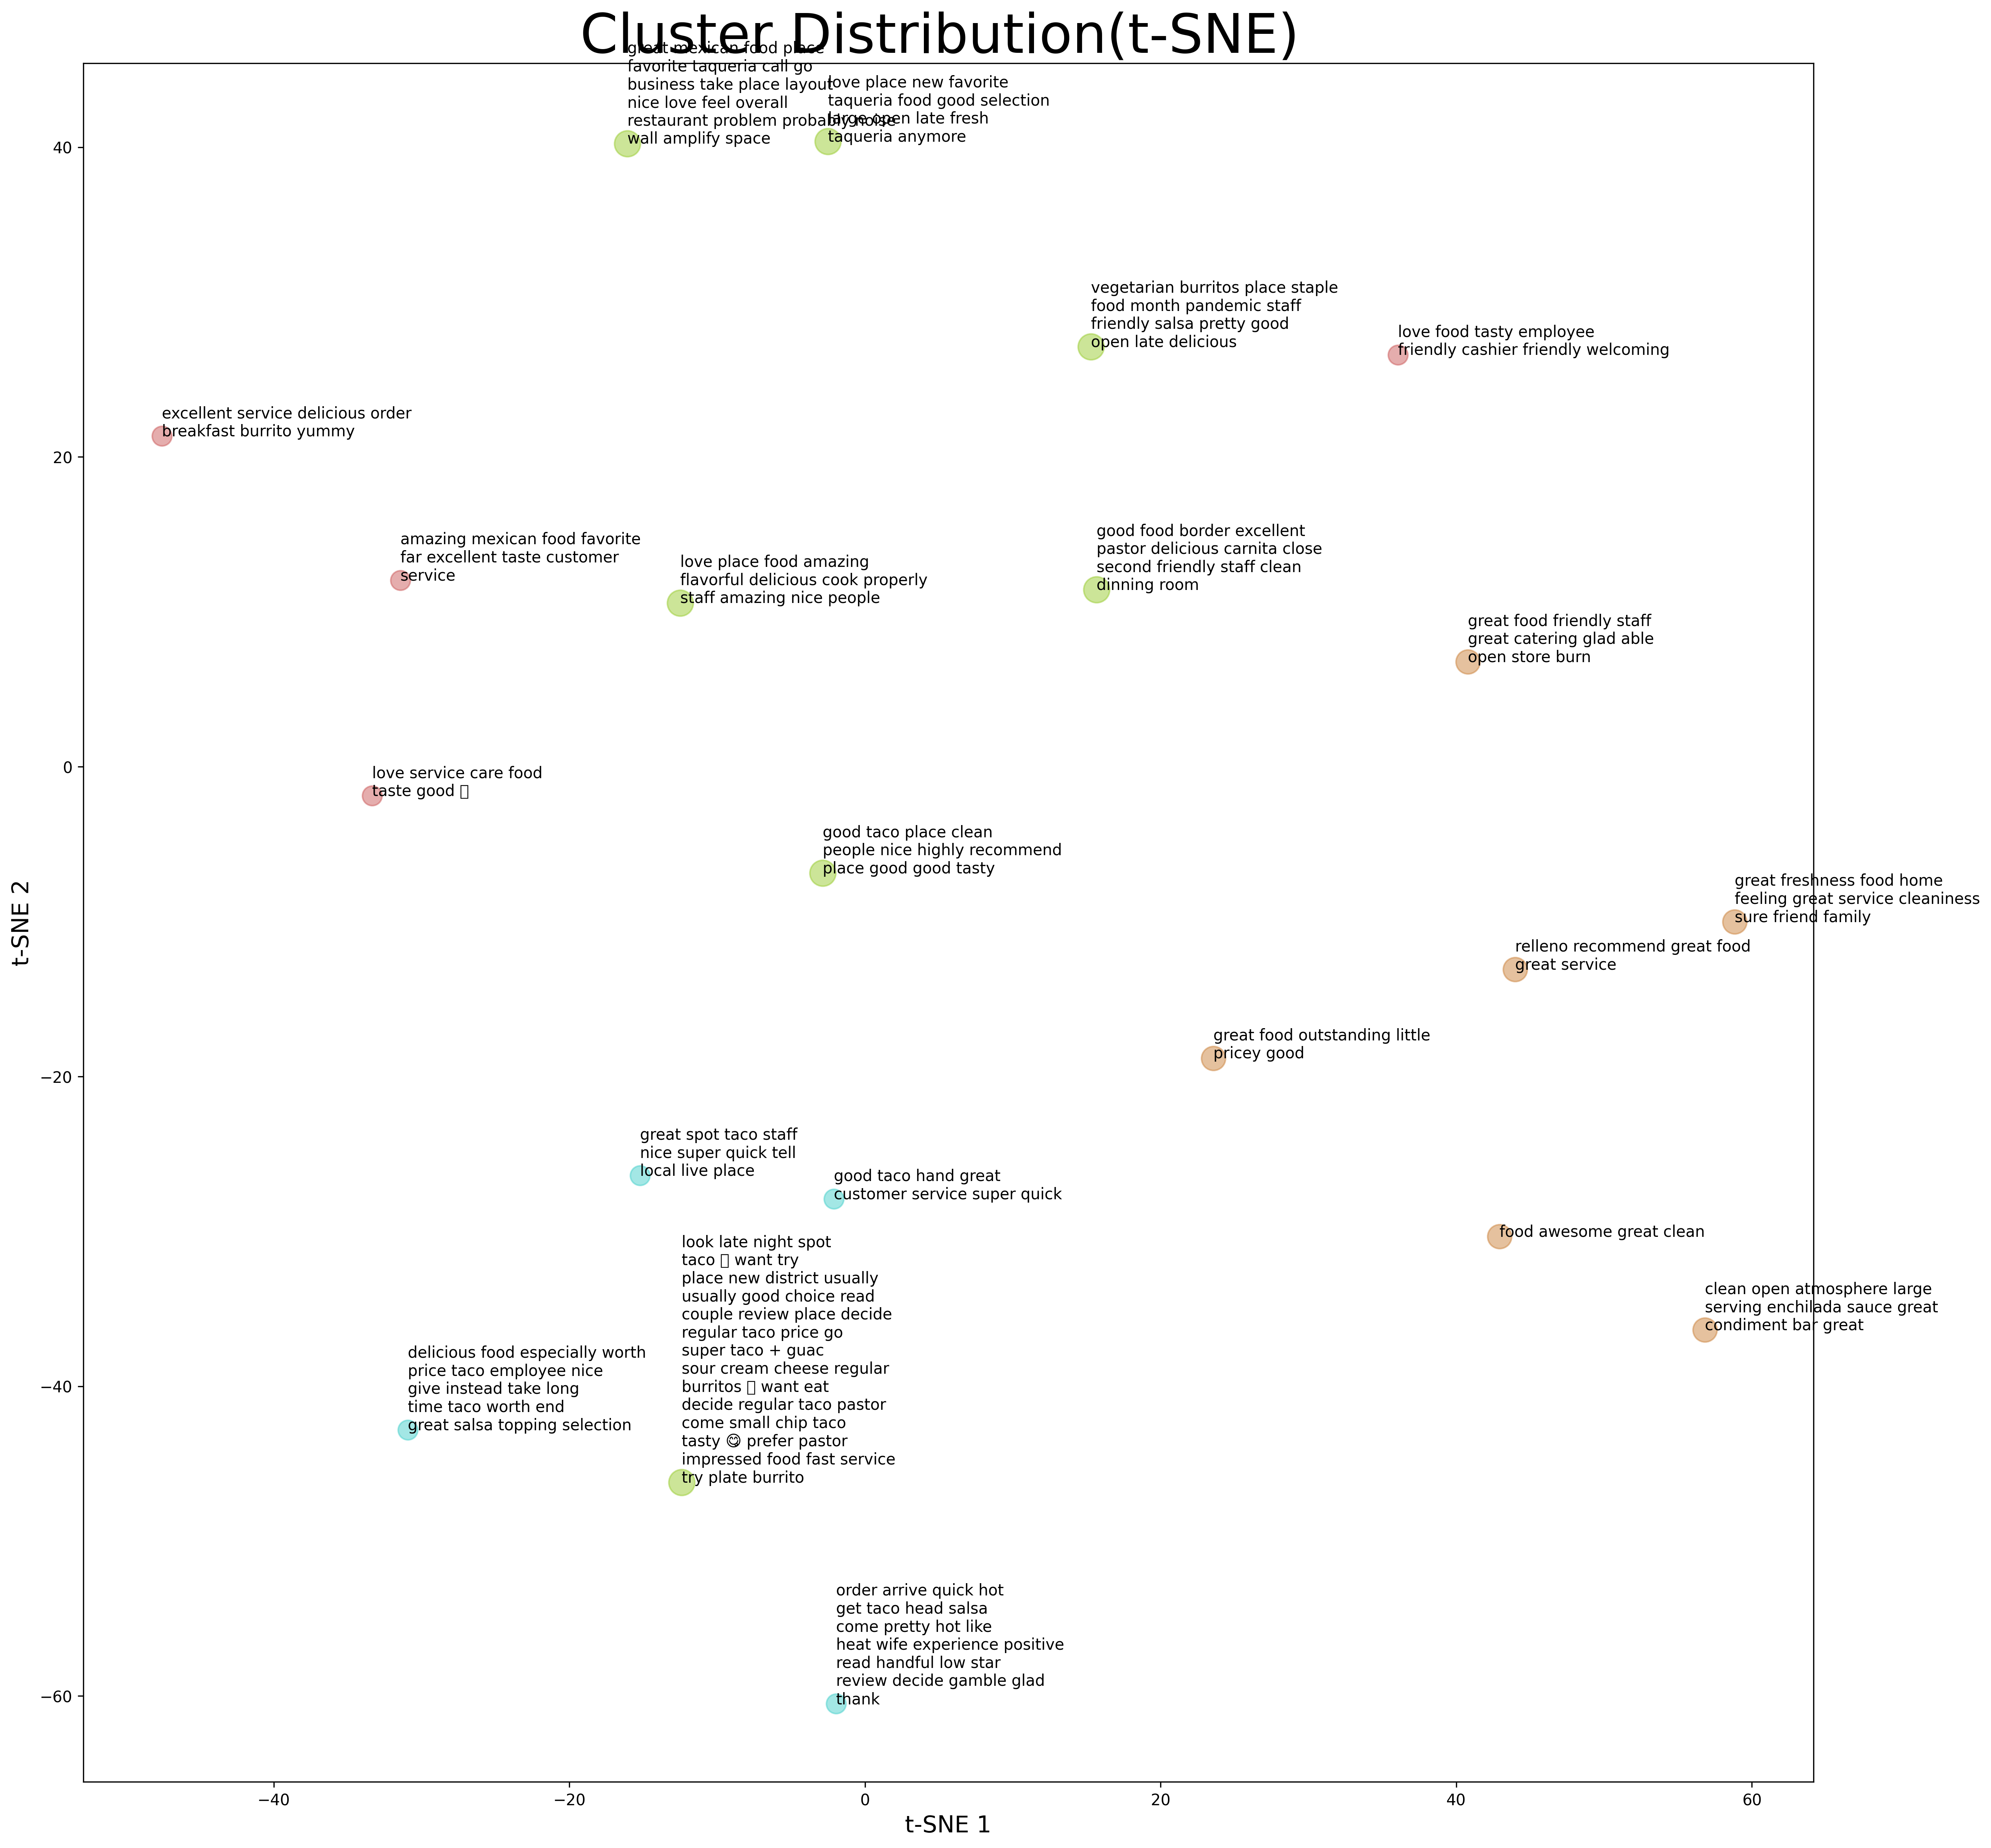

In [91]:
tsne = TSNE(n_components=2, perplexity=10, random_state=0)
tsne_matrix = tsne.fit_transform(pos_feature_matrix.toarray())

# create scatterplot of the data
plt.figure(figsize=(20,20), dpi=300)

for i in range(num_clusters):
    cluster_data = google_positive_comment_df[google_positive_comment_df['Cluster'] == i]
    plt.scatter(tsne_matrix[km_clusters==i, 0], tsne_matrix[km_clusters==i, 1], c=colors[i], alpha=0.5, label=f'Cluster {i}', s=cluster_data.shape[0]*40)
    for j, txt in enumerate(google_positive_comment_df[google_positive_comment_df['Cluster'] == i]['comment']):
        words = txt.split()
        txt_lines = [words[k:k+4] for k in range(0, len(words), 4)]  
        txt = '\n'.join([' '.join(line) for line in txt_lines]) 
        plt.annotate(txt, (tsne_matrix[km_clusters==i, 0][j], tsne_matrix[km_clusters==i, 1][j]), fontsize=10)

plt.title('Cluster Distribution(t-SNE) ')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

### Depict wordcloud

In [92]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [93]:
import random

In [94]:
from collections import Counter

neg_fdist_count = Counter(Neg_fdist)
pos_fdist_count = Counter(Pos_fdist)

In [95]:
# Prepared font
import wget
wget.download("https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download","TaipeiSansTCBeta-Regular.ttf")

'TaipeiSansTCBeta-Regular.ttf'

In [96]:
import matplotlib.patches as patches
from wordcloud import WordCloud
from PIL import Image

In [97]:
def plot_wordcloud(mytitle, seg_list):

  fig, ax = plt.subplots(figsize=(6, 6), dpi=300)  # Create a figure and axes

  
  colormaps = ['plasma', 'inferno', 'magma', 'viridis', 'cividis', 'twilight', 'tab10']
  
  random_colormap = random.choice(colormaps)

  wc = WordCloud(
      width=1500,
      height=1500,
      background_color='white',               
      max_words=150,                    
      max_font_size=None,                   
      font_path="TaipeiSansTCBeta-Regular.ttf",
      regexp=r"\w+(?:[-']\w+)*",
      random_state=50,                      
      contour_width=1,  
      contour_color='black',  
      colormap=random_colormap,  
      prefer_horizontal=0.9)               

  wc.generate_from_frequencies(seg_list)
  # Add a border to the plot
  border = patches.Rectangle((0, 0), 1500, 1500, linewidth=2, edgecolor='black', facecolor='none')
  ax.add_patch(border)


  # Plot
  plt.axis("off")
  plt.imshow(wc, interpolation="bilinear")
  plt.title(mytitle, fontsize=24, color='#0a9396', pad=4)

  plt.show()

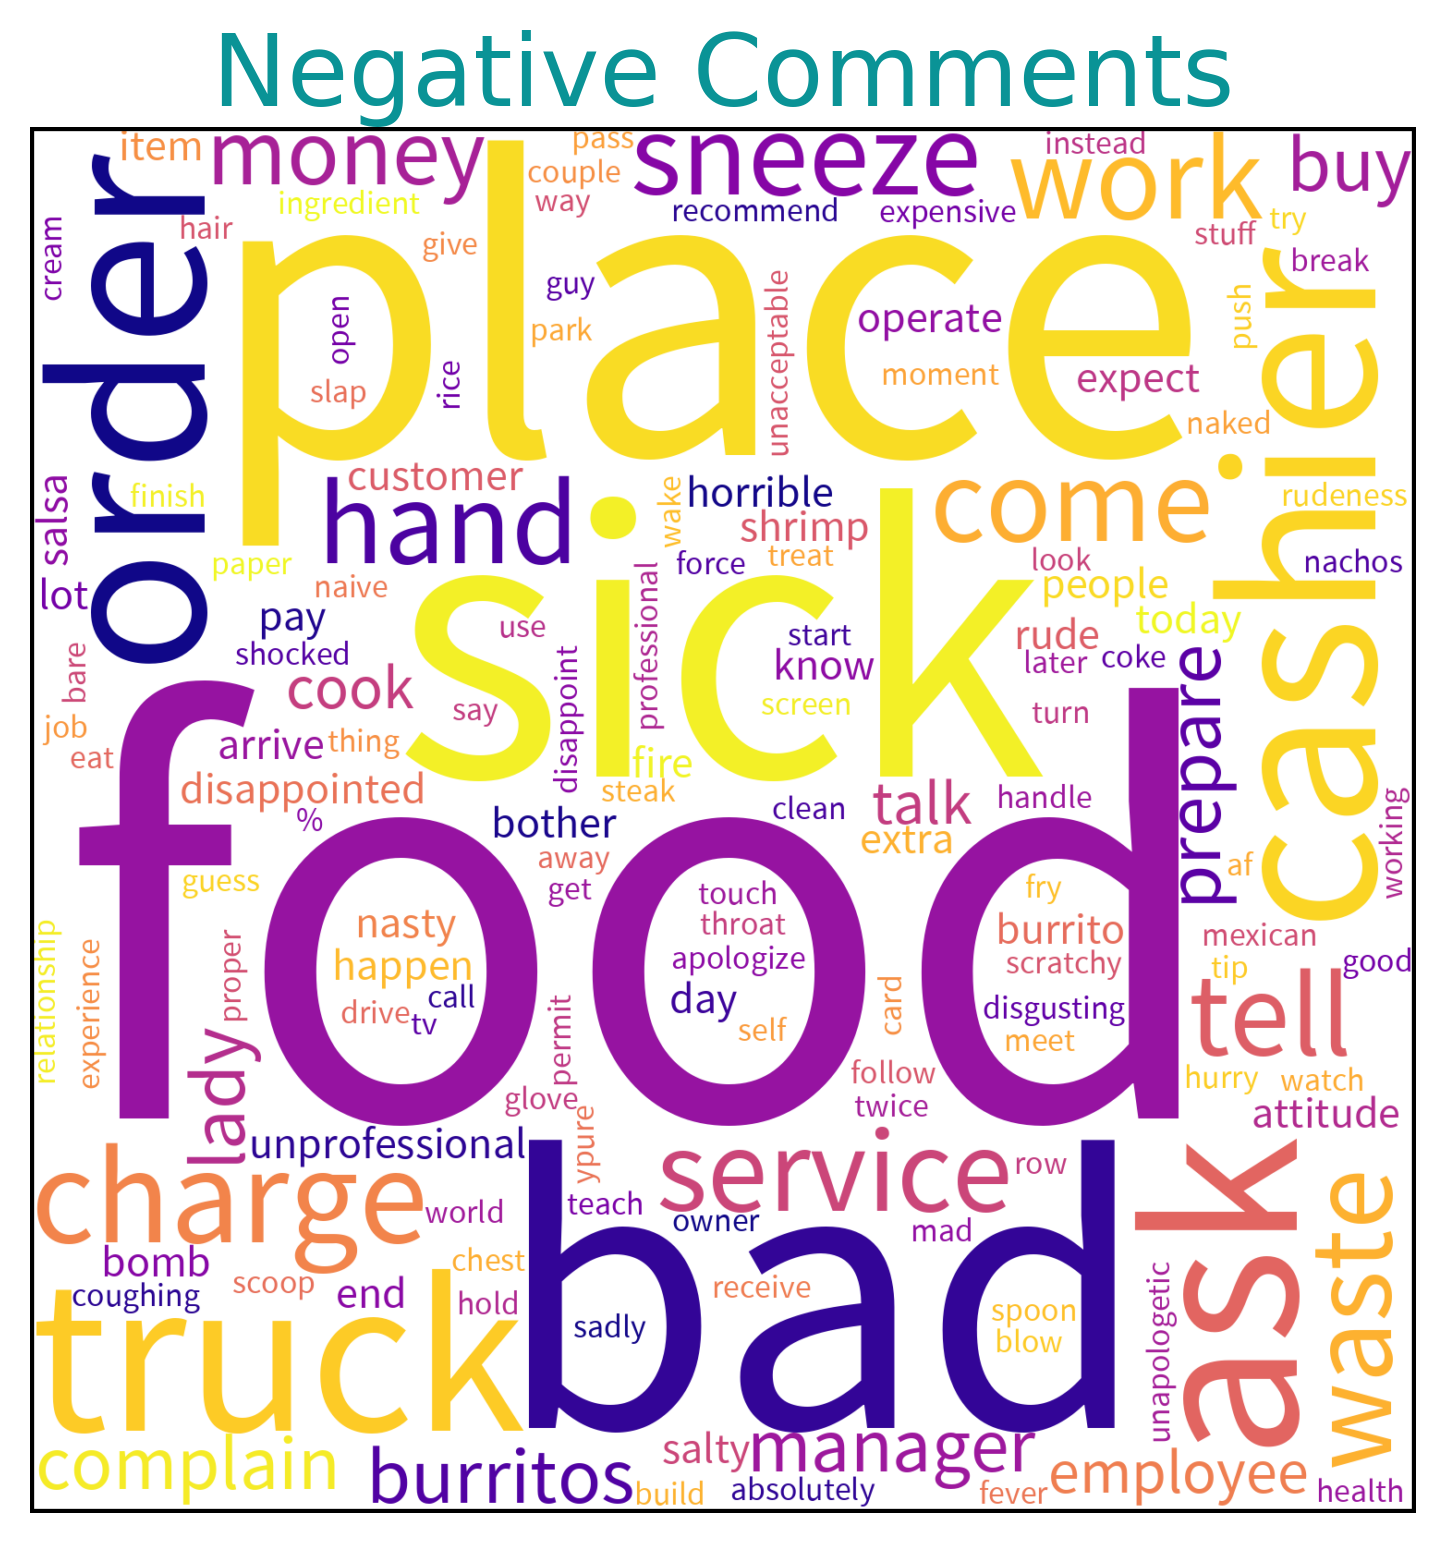

In [98]:
plot_wordcloud("Negative Comments", neg_fdist_count)

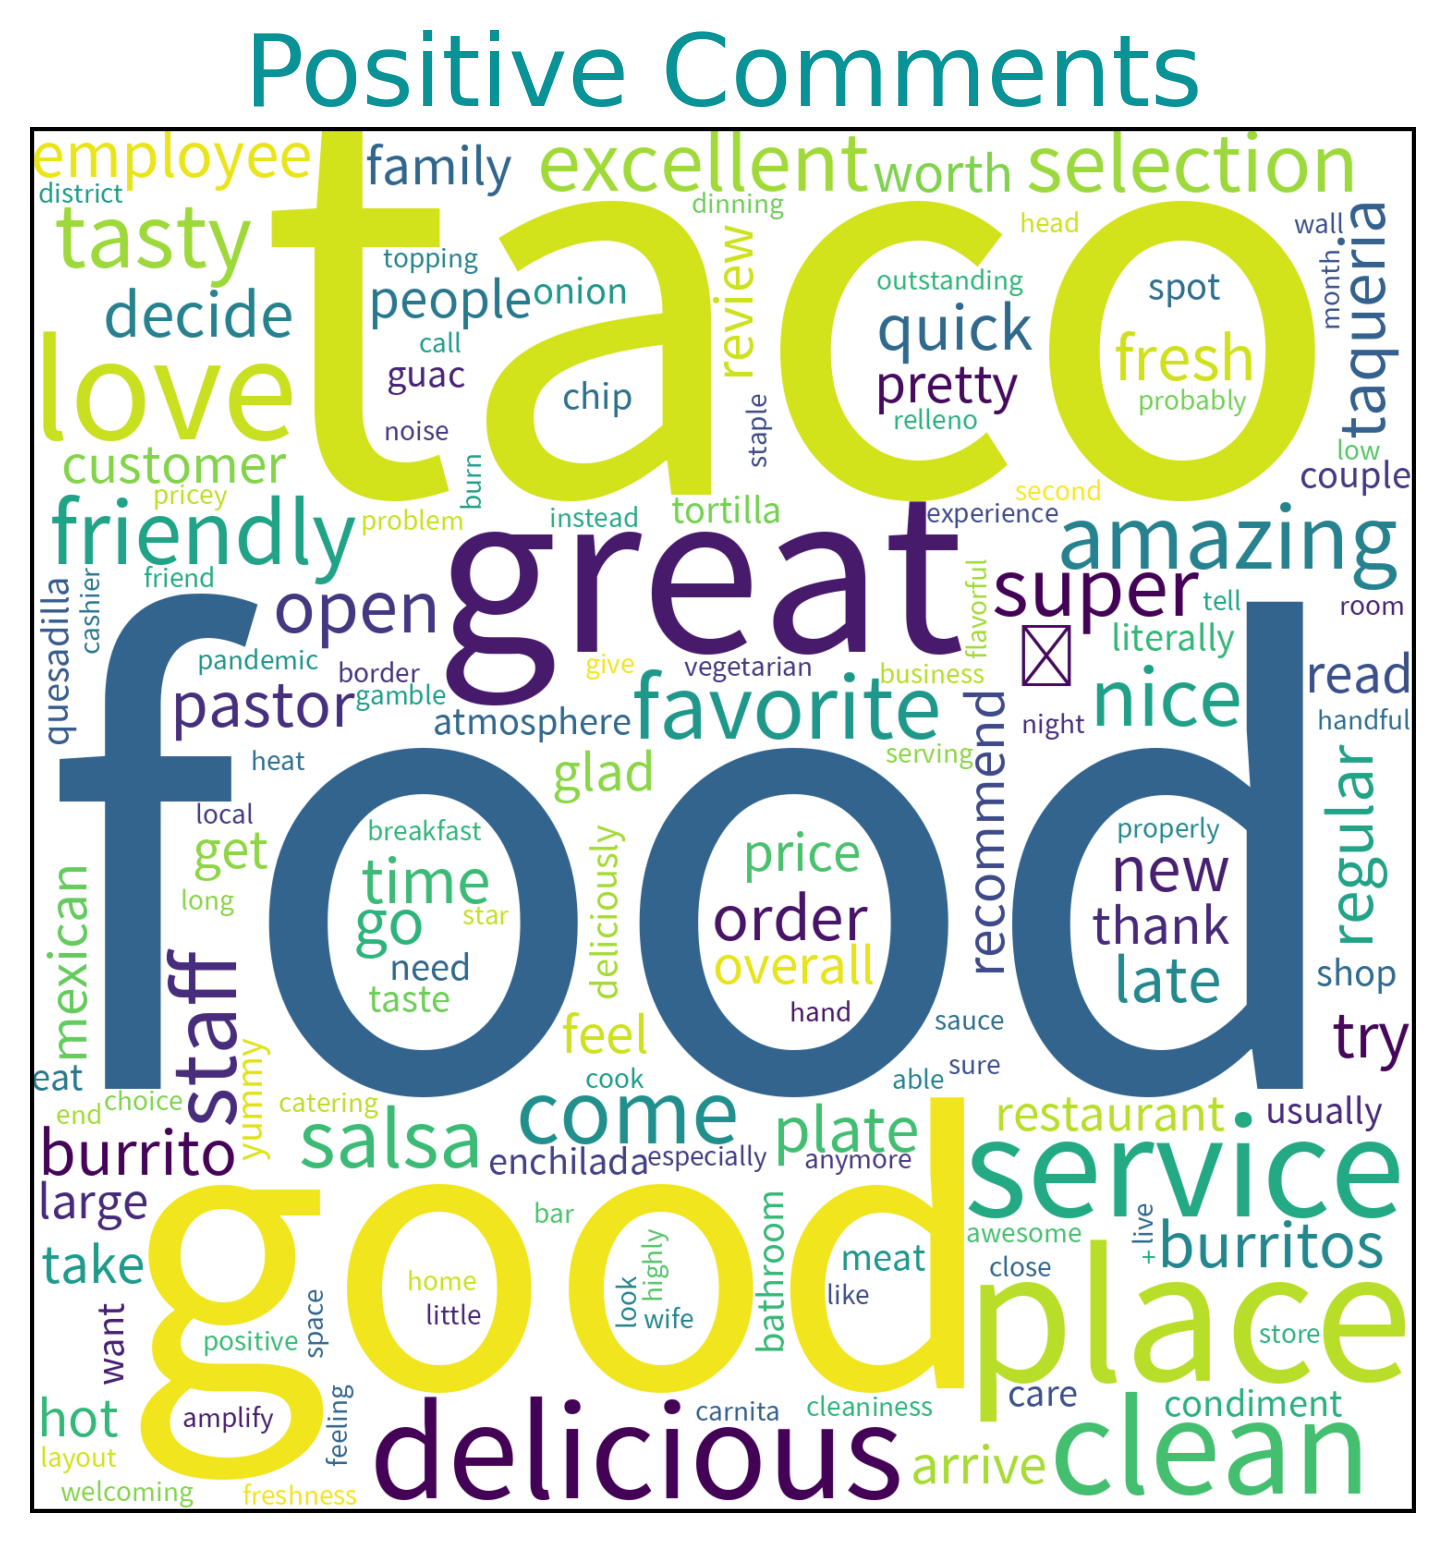

In [99]:
plot_wordcloud("Positive Comments", pos_fdist_count)